1) handle missing values
2) check correlation cat with target
3) feature engineering - divide cabin, passenger_id, check last name , age_bin 
4) check outliers 
5) transformer for numerical (probably e)
6) coding categories cols
7) try classic - logictic_regression, random forest, cat_boost 
8) try more sophisticated - deep learning 

In [480]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report, f1_score

from catboost import CatBoostClassifier, Pool

# Read data

In [3]:
data = '../data/spaceship-titanic/train.csv'

In [4]:
df = pd.read_csv(data)

# EDA

In [5]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


<Axes: xlabel='Transported'>

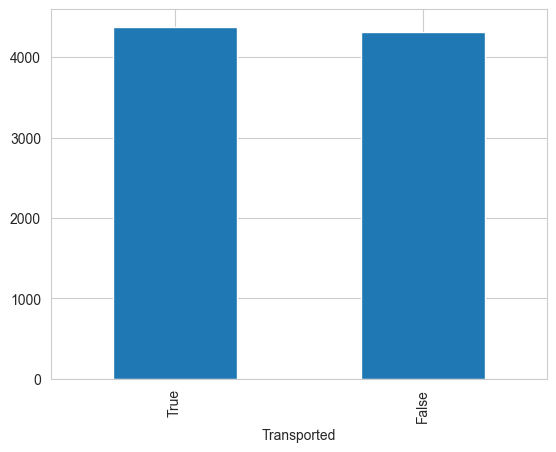

In [6]:
df['Transported'].value_counts().plot(kind='bar')

In [7]:
df.shape

(8693, 14)

In [8]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [10]:
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [11]:
cat_cols = df.select_dtypes(include='object').columns.tolist()

In [12]:
num_cols = df.select_dtypes(include='float64').columns.tolist()

In [13]:
bill_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [14]:
num_cols

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [15]:
cat_cols

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'VIP',
 'Name']

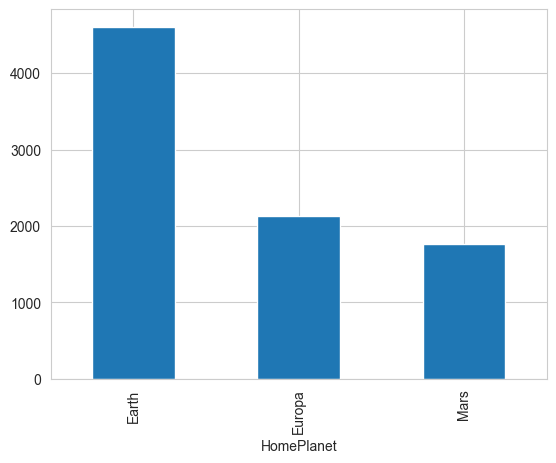

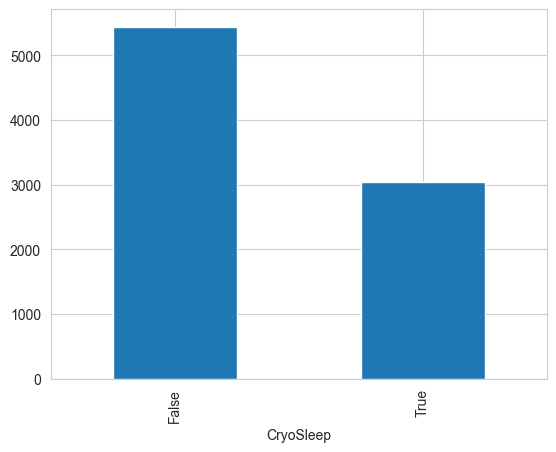

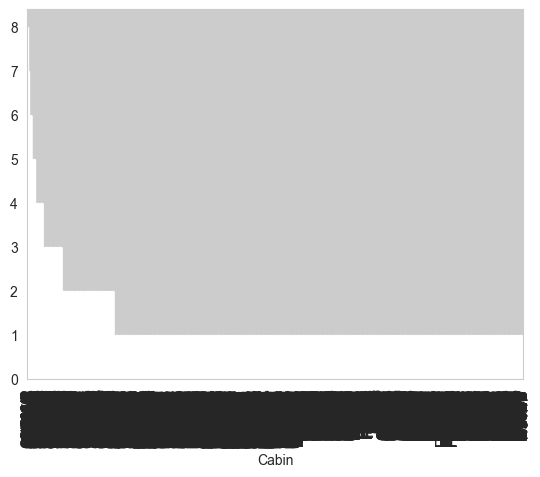

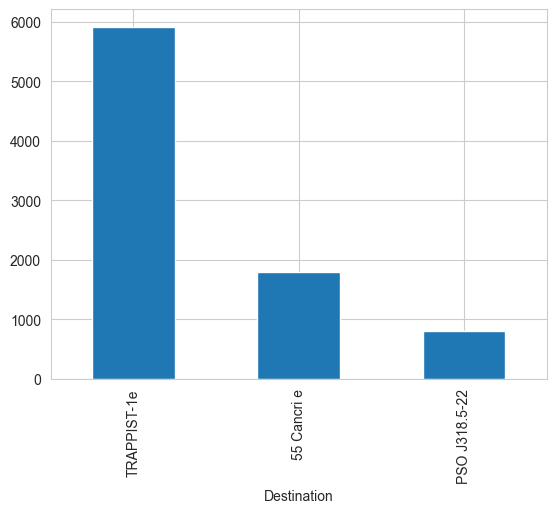

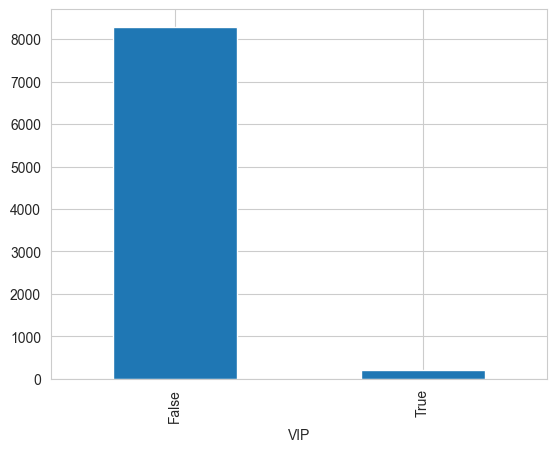

In [16]:
for col in cat_cols[1:-1]:
    df[col].value_counts().plot(kind='bar')
    plt.show()

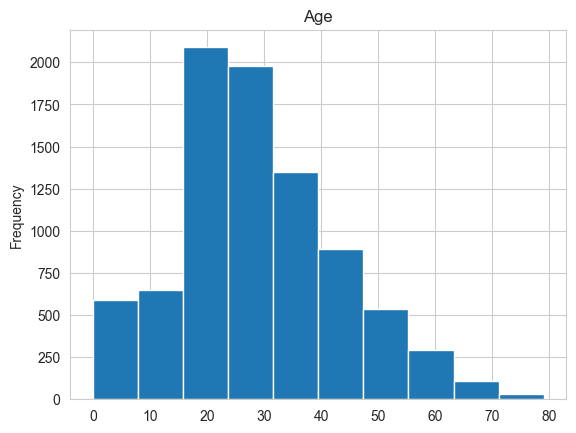

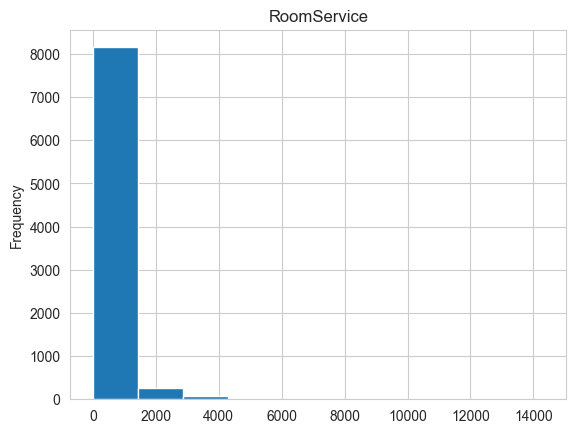

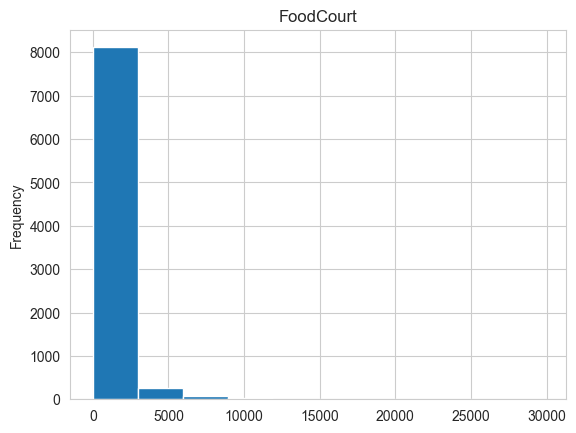

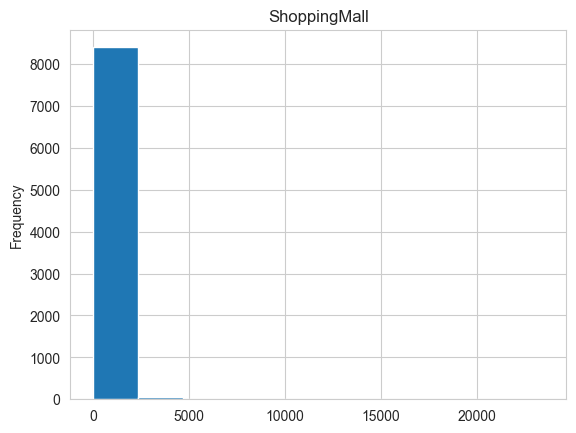

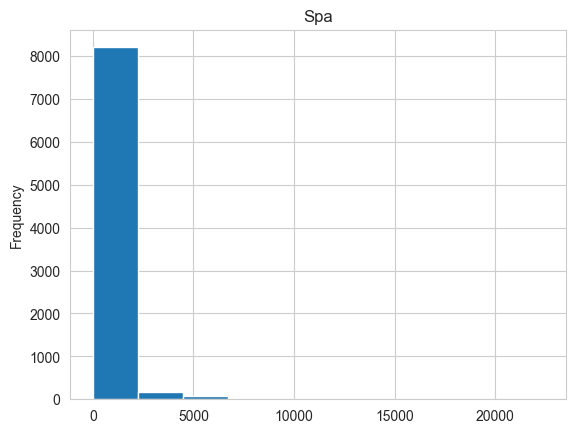

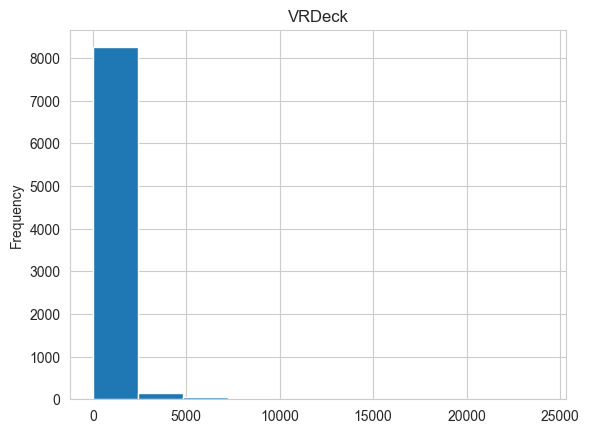

In [17]:
for col in num_cols:
    df[col].plot(kind='hist')
    plt.title(col)
    plt.show()

In [18]:
df['target'] = df.apply(lambda row: 0 if row['Transported'] == False else 1, axis=1)

<Axes: xlabel='target'>

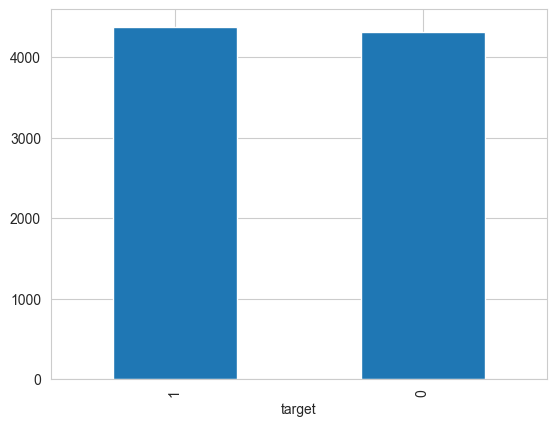

In [19]:
df['target'].value_counts().plot(kind='bar')

In [20]:
corr = df[num_cols + ['target']].corr()

<Axes: >

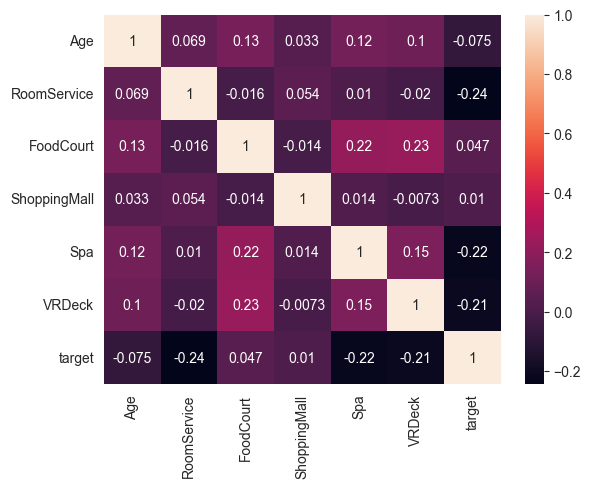

In [21]:
sns.heatmap(corr, annot=True)

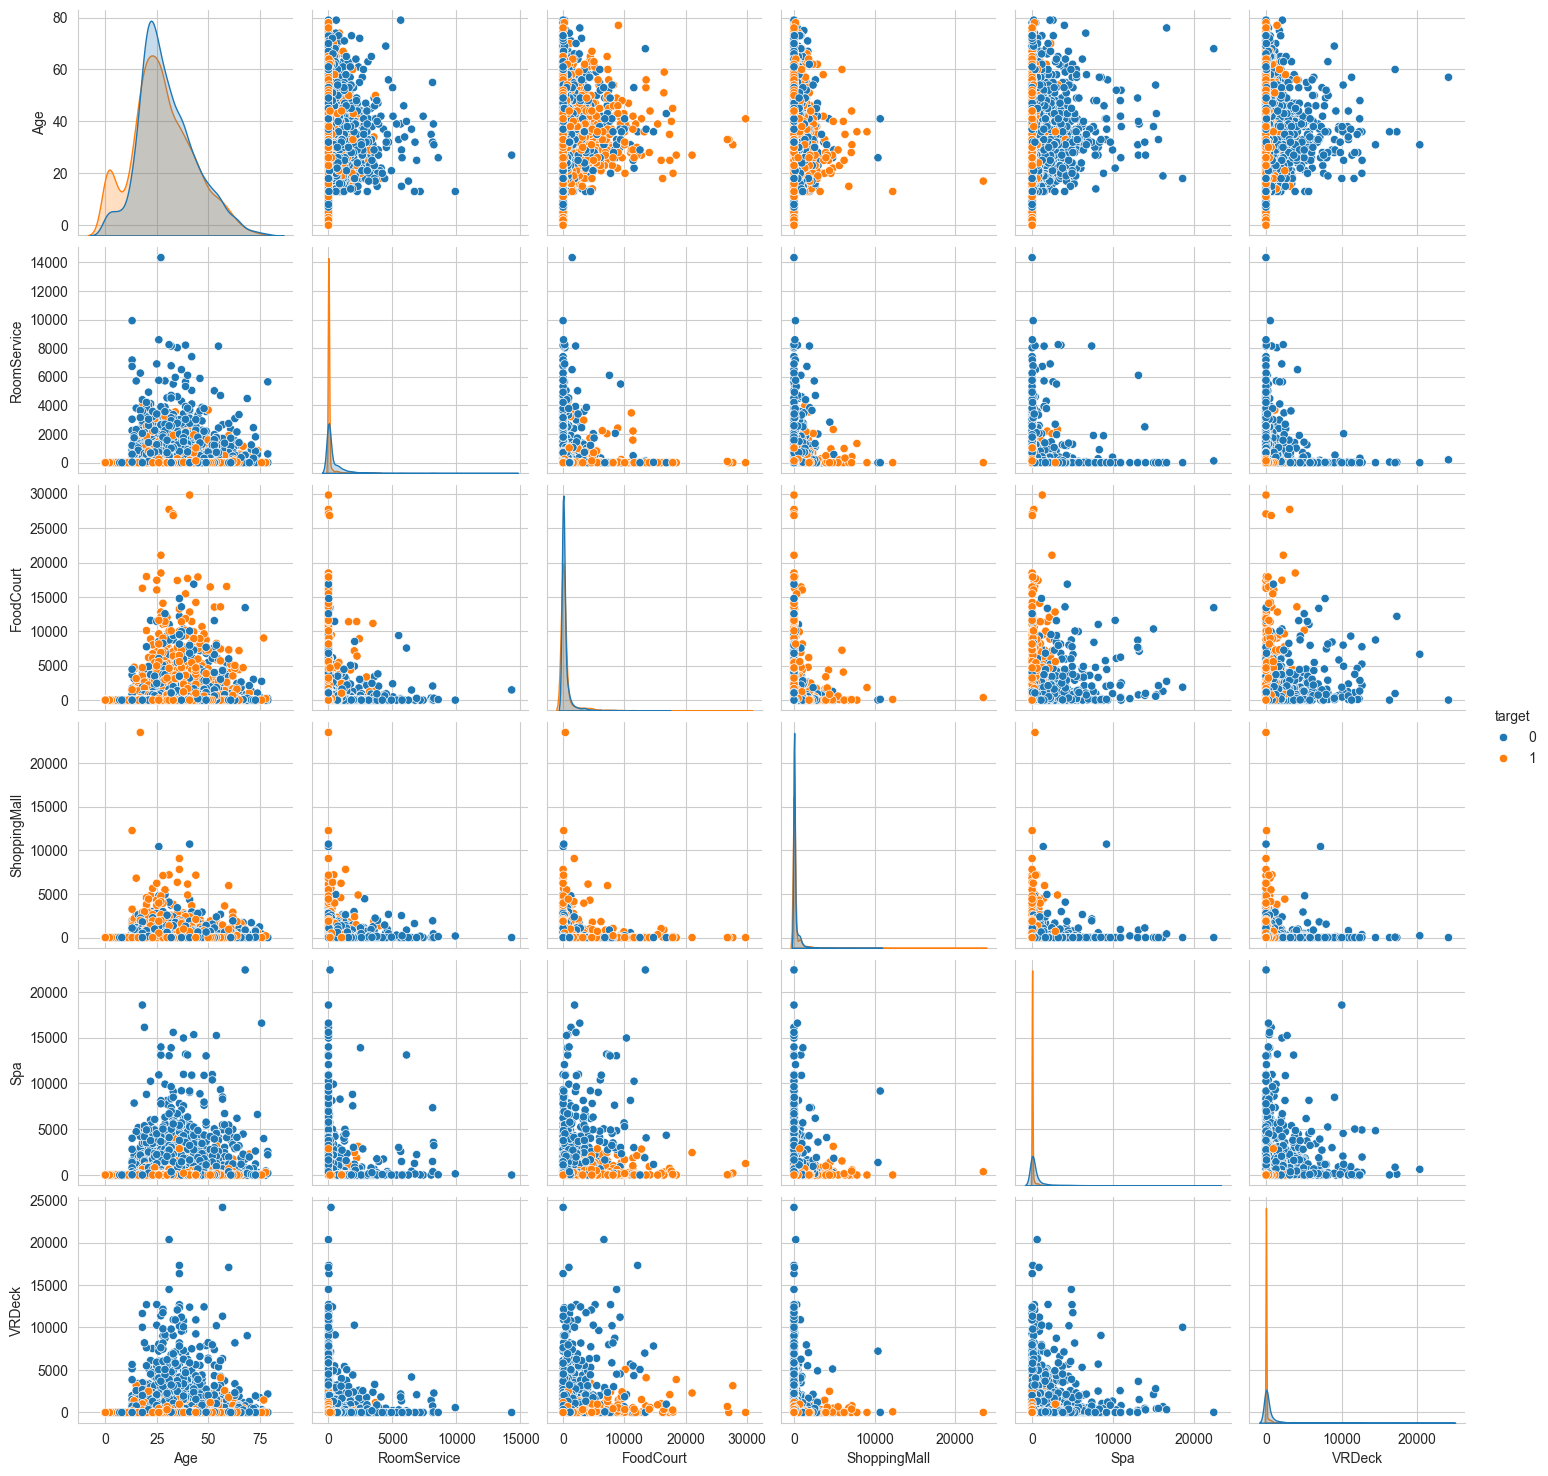

In [22]:
sns.pairplot(df[num_cols + ['target']], hue='target')

# Threshold model

In [228]:
df_org = pd.read_csv(data)

In [229]:
df_org[df_org.isna().sum(axis=1) == 1].shape

(1867, 14)

In [93]:
df_org

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,0
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,0
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,1
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,0


In [94]:
df_org['Transported'] = df_org.apply(lambda row: 1 if row['Transported'] == True else 0, axis=1)

In [95]:
df_org = df_org.dropna()

In [96]:
X_train_org, X_test_org, y_train_org, y_test_org = train_test_split(df_org.drop('Transported', axis=1), df_org['Transported'], test_size=0.2, random_state=42)

In [97]:
cat = [cols for cols in cat_cols if cols in df_org]

In [98]:
cat

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'VIP',
 'Name']

In [99]:
model = CatBoostClassifier(loss_function='Logloss',
                           verbose=True, cat_features=cat)

In [ ]:
model.fit(X_train_org, y_train_org)

In [102]:
# make the prediction using the resulting model
preds_class = model.predict(X_test_org)
preds_proba = model.predict_proba(X_test_org)

In [103]:
print(classification_report(y_test_org, preds_class))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       653
           1       0.78      0.86      0.82       669

    accuracy                           0.80      1322
   macro avg       0.81      0.80      0.80      1322
weighted avg       0.81      0.80      0.80      1322



In [105]:
f1_score(y_test_org, preds_class)

0.8159771754636234

# Feature Engineering

In [23]:
df['group'] = df.apply(lambda row: row['PassengerId'].split('_')[0], axis=1)
df['num_group'] = df.apply(lambda row: row['PassengerId'].split('_')[1], axis=1)

In [24]:
df['deck'] = df.apply(lambda row: row['Cabin'].split('/')[0] if pd.notna(row['Cabin']) else row['Cabin'] , axis=1)
df['num_cabin'] = df.apply(lambda row: row['Cabin'].split('/')[1] if pd.notna(row['Cabin']) else row['Cabin'], axis=1)
df['side_cabin'] = df.apply(lambda row: row['Cabin'].split('/')[2] if pd.notna(row['Cabin']) else row['Cabin'], axis=1)

In [25]:
df['last_name'] = df.apply(lambda row: row['Name'].split()[1] if pd.notna(row['Name']) else row['Name'], axis=1)

In [120]:
df_temp = df.copy()

In [126]:
df_temp['total_spending'] = df_temp.apply(lambda row: row[bill_cols].sum(), axis=1)

<Axes: xlabel='total_spending', ylabel='Count'>

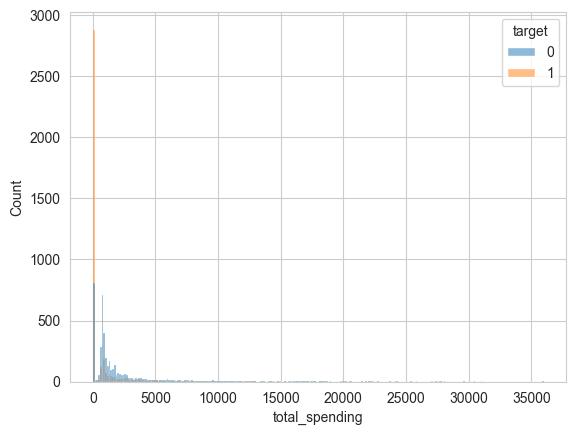

In [132]:
sns.histplot(df_temp, x='total_spending', hue='target')

In [134]:
df_temp[['total_spending', 'target']].corr()

,total_spending,target
total_spending,1.000000,-0.199514
target,-0.199514,1.000000


In [136]:
luxury_cols = ['Spa', 'RoomService', 'VRDeck']

In [137]:
df_temp['total_spending_luxuries'] = df_temp.apply(lambda row: row[luxury_cols].sum(), axis=1)

<Axes: xlabel='total_spending_luxuries', ylabel='Count'>

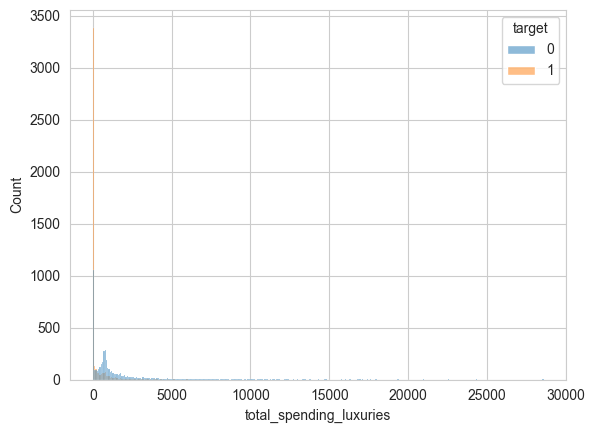

In [138]:
sns.histplot(df_temp, x='total_spending_luxuries', hue='target')

In [139]:
df_temp[['total_spending_luxuries', 'target']].corr()

,total_spending_luxuries,target
total_spending_luxuries,1.000000,-0.348244
target,-0.348244,1.000000


# Handling missing values

In [26]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,Maham Ofracculy,False,0,0001,01,B,0,P,Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,44.0,Juanna Vines,True,1,0002,01,F,0,S,Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,49.0,Altark Susent,False,0,0003,01,A,0,S,Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,193.0,Solam Susent,False,0,0003,02,A,0,S,Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,2.0,Willy Santantines,True,1,0004,01,F,1,S,Santantines


In [27]:
temp = df.groupby('group').size().reset_index(name='group_size')

In [28]:
temp['group'] = temp['group'].astype('object')

In [29]:
df = df.merge(temp, how='left', on='group')

In [31]:
temp['group_size'].value_counts()

group_size
1    4805
2     841
3     340
4     103
5      53
7      33
6      29
8      13
Name: count, dtype: int64

In [32]:
temp[temp['group_size'] > 4]

,group,group_size
16,0020,6
143,0220,7
144,0221,7
247,0378,7
334,0504,6
...,...,...
6073,9069,5
6077,9074,6
6084,9081,8
6132,9157,7


In [33]:
df[df['group'] == '0220']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size
196,0220_01,Earth,True,G/37/P,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,...,Tyle Wilsoney,True,1,0220,01,G,37,P,Wilsoney,7
197,0220_02,Earth,False,G/37/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,...,Wena Wilsoney,True,1,0220,02,G,37,P,Wilsoney,7
198,0220_03,Earth,True,G/37/P,TRAPPIST-1e,13.0,False,0.0,0.0,0.0,...,Branca Wilsoney,False,0,0220,03,G,37,P,Wilsoney,7
199,0220_04,Earth,False,E/10/P,TRAPPIST-1e,25.0,False,122.0,84.0,NaN,...,Dont Wilsoney,False,0,0220,04,E,10,P,Wilsoney,7
200,0220_05,Earth,False,F/48/P,TRAPPIST-1e,16.0,False,0.0,3.0,0.0,...,Velyne Wilsoney,False,0,0220,05,F,48,P,Wilsoney,7
201,0220_06,Earth,False,G/37/P,55 Cancri e,1.0,False,0.0,0.0,0.0,...,Weney Wilsoney,False,0,0220,06,G,37,P,Wilsoney,7
202,0220_07,Earth,True,G/37/P,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,...,Guye Wilsoney,True,1,0220,07,G,37,P,Wilsoney,7


In [34]:
df[df['group'] == '0571']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size
537,0571_01,Europa,True,C/21/P,55 Cancri e,22.0,False,0.0,0.0,0.0,...,Branev Ousious,True,1,0571,01,C,21,P,Ousious,7
538,0571_02,Europa,True,C/21/P,TRAPPIST-1e,19.0,False,0.0,0.0,0.0,...,Alchium Ousious,False,0,0571,02,C,21,P,Ousious,7
539,0571_03,Europa,True,C/21/P,TRAPPIST-1e,42.0,False,0.0,0.0,0.0,...,Bahoton Ousious,True,1,0571,03,C,21,P,Ousious,7
540,0571_04,Europa,True,C/21/P,NaN,30.0,False,0.0,0.0,0.0,...,Izark Hednigic,True,1,0571,04,C,21,P,Hednigic,7
541,0571_05,Europa,True,C/21/P,55 Cancri e,16.0,False,0.0,0.0,0.0,...,Polam Ousious,True,1,0571,05,C,21,P,Ousious,7
542,0571_06,Europa,False,C/21/P,TRAPPIST-1e,55.0,False,0.0,1542.0,0.0,...,Hasich Ousious,False,0,0571,06,C,21,P,Ousious,7
543,0571_07,Europa,True,C/21/P,TRAPPIST-1e,55.0,False,0.0,0.0,0.0,...,Isoton Ousious,True,1,0571,07,C,21,P,Ousious,7


In [35]:
df[df['group'] == '0714']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size
684,0714_01,Earth,True,G/109/P,PSO J318.5-22,38.0,False,0.0,0.0,0.0,...,Erie Rilley,True,1,0714,01,G,109,P,Rilley,7
685,0714_02,Earth,False,G/109/P,TRAPPIST-1e,1.0,False,0.0,0.0,0.0,...,Claine Rilley,False,0,0714,02,G,109,P,Rilley,7
686,0714_03,Earth,False,G/109/P,NaN,12.0,False,0.0,0.0,NaN,...,Sony Rilley,True,1,0714,03,G,109,P,Rilley,7
687,0714_04,Earth,True,G/109/P,PSO J318.5-22,2.0,False,0.0,0.0,0.0,...,Charry Rilley,False,0,0714,04,G,109,P,Rilley,7
688,0714_05,Earth,True,G/109/P,PSO J318.5-22,25.0,False,0.0,0.0,0.0,...,Jeanny Rilley,False,0,0714,05,G,109,P,Rilley,7
689,0714_06,Earth,True,G/109/P,55 Cancri e,1.0,False,0.0,0.0,0.0,...,Man Rilley,True,1,0714,06,G,109,P,Rilley,7
690,0714_07,Earth,True,G/109/P,55 Cancri e,0.0,False,0.0,0.0,0.0,...,Brene Rilley,True,1,0714,07,G,109,P,Rilley,7


In [36]:
df[df['group'] == '1709']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size
1608,1709_01,Mars,False,F/326/S,TRAPPIST-1e,23.0,False,31.0,0.0,1247.0,...,Jurbet Minen,False,0,1709,01,F,326,S,Minen,7
1609,1709_02,Mars,False,D/61/S,TRAPPIST-1e,23.0,False,2210.0,0.0,89.0,...,Bet Minen,True,1,1709,02,D,61,S,Minen,7
1610,1709_03,Mars,False,NaN,TRAPPIST-1e,35.0,False,1313.0,0.0,24.0,...,Bleark Minen,False,0,1709,03,NaN,NaN,NaN,Minen,7
1611,1709_04,Mars,False,E/127/S,TRAPPIST-1e,17.0,False,1744.0,0.0,136.0,...,Donut Minen,False,0,1709,04,E,127,S,Minen,7
1612,1709_05,Mars,True,F/326/S,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,...,Fams Minen,True,1,1709,05,F,326,S,Minen,7
1613,1709_06,Mars,False,D/61/S,TRAPPIST-1e,15.0,False,1554.0,0.0,646.0,...,Tyog Minen,False,0,1709,06,D,61,S,Minen,7
1614,1709_07,Mars,False,F/326/S,TRAPPIST-1e,19.0,False,285.0,54.0,1246.0,...,Cocowl Minen,False,0,1709,07,F,326,S,Minen,7


In [37]:
df[df['CryoSleep'].isna()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size
92,0099_02,Earth,NaN,G/12/P,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,...,Thewis Connelson,True,1,0099,02,G,12,P,Connelson,2
98,0105_01,Earth,NaN,F/21/P,TRAPPIST-1e,27.0,False,0.0,0.0,570.0,...,Carry Cleachrand,False,0,0105,01,F,21,P,Cleachrand,1
104,0110_02,Europa,NaN,B/5/P,TRAPPIST-1e,40.0,False,0.0,331.0,0.0,...,Aldeba Bootious,False,0,0110,02,B,5,P,Bootious,4
111,0115_01,Mars,NaN,F/24/P,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,...,Rohs Pead,True,1,0115,01,F,24,P,Pead,1
152,0173_01,Earth,NaN,E/11/S,TRAPPIST-1e,58.0,False,0.0,985.0,0.0,...,Hilip Grifford,True,1,0173,01,E,11,S,Grifford,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8620,9197_01,Europa,NaN,C/308/P,55 Cancri e,44.0,False,0.0,0.0,0.0,...,Bellus Platch,True,1,9197,01,C,308,P,Platch,4
8651,9227_05,Earth,NaN,G/1498/P,TRAPPIST-1e,8.0,False,0.0,0.0,0.0,...,Hard Hinglendez,False,0,9227,05,G,1498,P,Hinglendez,5
8664,9246_01,Earth,NaN,G/1490/S,TRAPPIST-1e,32.0,False,0.0,0.0,0.0,...,NaN,True,1,9246,01,G,1490,S,NaN,1
8675,9259_01,Earth,NaN,F/1893/P,TRAPPIST-1e,44.0,False,1030.0,1015.0,0.0,...,Annah Gilleyons,True,1,9259,01,F,1893,P,Gilleyons,1


In [38]:
df[(df['CryoSleep'] == True) & (df[bill_cols].gt(0).any(axis=1))]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size


In [39]:
df[(df['CryoSleep'] == True) & (df[bill_cols].isna().any(axis=1))][bill_cols].fillna(0.0, inplace=True)

In [40]:
filtered_rows = (df['CryoSleep'] == True) & (df[bill_cols].isna().any(axis=1))

imput 0 to bill cols when person is in CryoSleep (they are confined to their cabins)

In [41]:
df.loc[filtered_rows, bill_cols] = df.loc[filtered_rows, bill_cols].fillna(0.0)

In [42]:
df[(df['CryoSleep'] == False) & (df[bill_cols].isna().any(axis=1))]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size
16,0014_01,Mars,False,F/3/P,55 Cancri e,27.0,False,1286.0,122.0,NaN,...,Flats Eccle,False,0,0014,01,F,3,P,Eccle,1
35,0031_03,Mars,False,F/9/P,TRAPPIST-1e,20.0,False,NaN,0.0,1750.0,...,Dontch Datie,True,1,0031,03,F,9,P,Datie,3
48,0050_01,Earth,False,E/1/S,55 Cancri e,35.0,False,790.0,0.0,0.0,...,Sony Lancis,False,0,0050,01,E,1,S,Lancis,1
95,0103_01,Earth,False,F/24/S,TRAPPIST-1e,24.0,False,0.0,NaN,0.0,...,Arlen Mclainez,True,1,0103,01,F,24,S,Mclainez,3
132,0141_01,Mars,False,F/30/P,TRAPPIST-1e,31.0,False,NaN,0.0,97.0,...,Pyrohs Harte,False,0,0141,01,F,30,P,Harte,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8611,9192_01,Earth,False,F/1880/P,PSO J318.5-22,24.0,False,NaN,599.0,NaN,...,Norahe Drakeekss,True,1,9192,01,F,1880,P,Drakeekss,1
8623,9197_04,Europa,False,C/308/P,55 Cancri e,30.0,False,1569.0,NaN,0.0,...,Phecca Platch,False,0,9197,04,C,308,P,Platch,4
8633,9211_01,Earth,False,G/1486/S,TRAPPIST-1e,60.0,False,0.0,8.0,NaN,...,Stendy Steelerettt,False,0,9211,01,G,1486,S,Steelerettt,1
8641,9220_03,Earth,False,F/1886/P,PSO J318.5-22,22.0,False,623.0,0.0,NaN,...,Kennie Barrilloney,True,1,9220,03,F,1886,P,Barrilloney,3


## Check how to fill this with number

In [43]:
temp_2 = df[(df['CryoSleep'] == False) &  (df[bill_cols].gt(0) | df[bill_cols].isna()).all(axis=1)]

In [44]:
temp_2[temp_2[bill_cols].isna().any(axis=1)]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size
385,0427_01,Europa,False,E/26/P,TRAPPIST-1e,31.0,False,417.0,NaN,7185.0,...,Algor Efulows,True,1,0427,01,E,26,P,Efulows,1
401,0439_01,Europa,False,C/13/P,55 Cancri e,34.0,False,NaN,5637.0,45.0,...,Izarino Unciate,False,0,0439,01,C,13,P,Unciate,1
545,0573_01,Earth,False,F/117/P,TRAPPIST-1e,NaN,False,14.0,809.0,25.0,...,Deandy Dickley,False,0,0573,01,F,117,P,Dickley,1
583,0607_02,Europa,False,C/22/P,55 Cancri e,44.0,False,434.0,3113.0,19.0,...,Mino Hontichre,False,0,0607,02,C,22,P,Hontichre,3
584,0607_03,Europa,False,C/22/P,TRAPPIST-1e,43.0,False,4.0,1111.0,118.0,...,Pola Hontichre,False,0,0607,03,C,22,P,Hontichre,3
790,0828_02,Earth,False,F/159/S,TRAPPIST-1e,41.0,False,324.0,2.0,NaN,...,Rosey Santry,True,1,0828,02,F,159,S,Santry,2
989,1051_01,Earth,False,F/197/S,TRAPPIST-1e,21.0,False,2.0,447.0,81.0,...,Frandy Warrison,False,0,1051,01,F,197,S,Warrison,1
997,1060_01,Earth,False,G/166/S,TRAPPIST-1e,57.0,False,NaN,20.0,157.0,...,Willip Clayson,False,0,1060,01,G,166,S,Clayson,1
1057,1130_02,Mars,False,D/38/S,55 Cancri e,20.0,False,NaN,3.0,3505.0,...,Camonk Cako,True,1,1130,02,D,38,S,Cako,2
1336,1415_01,Europa,False,D/45/P,55 Cancri e,33.0,False,13.0,NaN,2011.0,...,Preo Higast,True,1,1415,01,D,45,P,Higast,1


In [45]:
df[(df['CryoSleep'] == False) & (df[bill_cols].eq(0).all(axis=1))]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,Maham Ofracculy,False,0,0001,01,B,0,P,Ofracculy,1
19,0017_01,Earth,False,G/0/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,...,Lyde Brighttt,True,1,0017,01,G,0,P,Brighttt,2
24,0020_04,Earth,False,E/0/S,TRAPPIST-1e,10.0,False,0.0,0.0,0.0,...,Breney Jacostanley,True,1,0020,04,E,0,S,Jacostanley,6
26,0020_06,Earth,False,E/0/S,TRAPPIST-1e,7.0,False,0.0,0.0,0.0,...,Terta Mcfaddennon,False,0,0020,06,E,0,S,Mcfaddennon,6
34,0031_02,Mars,False,F/9/P,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,...,Cinets Datie,True,1,0031,02,F,9,P,Datie,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8577,9157_06,Earth,False,G/1476/S,TRAPPIST-1e,12.0,False,0.0,0.0,0.0,...,Pamont Navages,False,0,9157,06,G,1476,S,Navages,7
8637,9219_01,Earth,False,G/1487/S,55 Cancri e,9.0,False,0.0,0.0,0.0,...,Daley Workmanson,False,0,9219,01,G,1487,S,Workmanson,2
8654,9231_02,Mars,False,F/1888/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,...,Walls Paie,True,1,9231,02,F,1888,P,Paie,3
8655,9231_03,Mars,False,E/592/P,TRAPPIST-1e,22.0,False,0.0,0.0,0.0,...,Cus Paie,False,0,9231,03,E,592,P,Paie,3


In [142]:
df[(df['CryoSleep'] == False) & (df[bill_cols].eq(0).all(axis=1))]['VIP'].value_counts(dropna=False)

VIP
False    450
NaN       14
True       6
Name: count, dtype: int64

In [145]:
vip_false = (df['CryoSleep'] == False) & (df[bill_cols].eq(0).all(axis=1)) & (df['VIP'].isna())

In [146]:
df.loc[vip_false, 'VIP'] = False

In [ ]:
vip_false = (df['CryoSleep'] == False) & (df[bill_cols].eq(0).all(axis=1)) & (df['VIP'].isna())
df.loc[vip_false, 'VIP'] = False

impute False to CryoSleep to people who have spendings (they cannot spend in CryoSleep)

In [46]:
cryosleep_false = (df['CryoSleep'].isna()) & (df[bill_cols].gt(0).any(axis=1))

In [47]:
df.loc[cryosleep_false, 'CryoSleep'] = False

/var/folders/7s/ctsz6mrn2736_l3pgbrc0n440000gn/T/ipykernel_35559/2269975521.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[cryosleep_false, 'CryoSleep'] = df.loc[cryosleep_false, 'CryoSleep'].fillna(False)


In [48]:
df[(df[bill_cols].eq(0).all(axis=1)) & (df['VIP'] == True)] 

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size
365,0402_01,NaN,True,D/15/S,55 Cancri e,32.0,True,0.0,0.0,0.0,...,Teron Sageng,True,1,0402,01,D,15,S,Sageng,1
589,0612_01,Europa,True,B/25/P,TRAPPIST-1e,27.0,True,0.0,0.0,0.0,...,Achyon Ranaly,True,1,0612,01,B,25,P,Ranaly,1
779,0818_01,Europa,False,B/29/S,TRAPPIST-1e,71.0,True,0.0,0.0,0.0,...,Ksorab Couseced,True,1,0818,01,B,29,S,Couseced,1
1606,1705_01,Mars,False,E/126/S,TRAPPIST-1e,29.0,True,0.0,0.0,0.0,...,Barave Chake,False,0,1705,01,E,126,S,Chake,1
1849,1976_03,Europa,True,B/82/S,55 Cancri e,26.0,True,0.0,0.0,0.0,...,Cellah Lansuffle,True,1,1976,03,B,82,S,Lansuffle,7
2394,2572_02,Europa,True,C/93/S,55 Cancri e,56.0,True,0.0,0.0,0.0,...,Spuri Suptibler,True,1,2572,02,C,93,S,Suptibler,2
2675,2866_01,Europa,True,C/110/S,TRAPPIST-1e,36.0,True,0.0,0.0,0.0,...,Hadirk Wheededly,True,1,2866,01,C,110,S,Wheededly,1
3046,3292_04,Europa,False,B/121/S,TRAPPIST-1e,25.0,True,0.0,0.0,0.0,...,Acruxon Discuous,True,1,3292,04,B,121,S,Discuous,5
3104,3349_01,Europa,True,C/111/P,TRAPPIST-1e,73.0,True,0.0,0.0,0.0,...,Sargin Brakeril,True,1,3349,01,C,111,P,Brakeril,1
4071,4348_01,Europa,True,B/142/P,TRAPPIST-1e,47.0,True,0.0,0.0,0.0,...,Krazet Conate,True,1,4348,01,B,142,P,Conate,1


In [148]:
df.isnull().sum()

PassengerId                  0
HomePlanet                 201
CryoSleep                   98
Cabin                      199
Destination                182
Age                        179
VIP                        189
RoomService                113
FoodCourt                  113
ShoppingMall               112
Spa                        118
VRDeck                     126
Name                       200
Transported                  0
target                       0
group                        0
num_group                    0
deck                       199
num_cabin                  199
side_cabin                 199
last_name                  200
group_size                   0
total_spending_luxuries      0
dtype: int64

In [51]:
df[df.isnull().any(axis=1)]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size
15,0012_01,Earth,False,NaN,TRAPPIST-1e,31.0,False,32.0,0.0,876.0,...,Justie Pooles,False,0,0012,01,NaN,NaN,NaN,Pooles,1
16,0014_01,Mars,False,F/3/P,55 Cancri e,27.0,False,1286.0,122.0,NaN,...,Flats Eccle,False,0,0014,01,F,3,P,Eccle,1
27,0022_01,Mars,False,D/0/P,TRAPPIST-1e,21.0,False,980.0,2.0,69.0,...,NaN,False,0,0022,01,D,0,P,NaN,1
35,0031_03,Mars,False,F/9/P,TRAPPIST-1e,20.0,False,NaN,0.0,1750.0,...,Dontch Datie,True,1,0031,03,F,9,P,Datie,3
38,0036_01,Earth,False,F/8/S,55 Cancri e,15.0,NaN,0.0,492.0,48.0,...,Marina Leodger,False,0,0036,01,F,8,S,Leodger,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8666,9248_01,NaN,False,F/1792/S,55 Cancri e,38.0,NaN,28.0,1208.0,973.0,...,Gian Perle,True,1,9248,01,F,1792,S,Perle,1
8667,9250_01,Europa,False,E/597/P,TRAPPIST-1e,29.0,False,0.0,2972.0,NaN,...,Chain Reedectied,True,1,9250,01,E,597,P,Reedectied,1
8674,9257_01,NaN,False,F/1892/P,TRAPPIST-1e,13.0,False,39.0,0.0,1085.0,...,Ties Apple,False,0,9257,01,F,1892,P,Apple,1
8675,9259_01,Earth,False,F/1893/P,TRAPPIST-1e,44.0,False,1030.0,1015.0,0.0,...,Annah Gilleyons,True,1,9259,01,F,1893,P,Gilleyons,1


In [52]:
len(df.columns) 

22

In [149]:
df[df.isna().sum(axis=1) == 3].shape

(33, 23)

In [150]:
df[df.isna().sum(axis=1) == 2].shape

(249, 23)

In [151]:
df[df.isna().sum(axis=1) == 1].shape

(1199, 23)

In [152]:
df[df.isna().sum(axis=1) == 3]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size,total_spending_luxuries
833,0890_01,Mars,False,F/184/P,TRAPPIST-1e,16.0,False,172.0,NaN,338.0,...,False,0,0890,01,F,184,P,NaN,1,181.0
1718,1829_01,Europa,False,D/56/P,55 Cancri e,48.0,False,0.0,3578.0,80.0,...,True,1,1829,01,D,56,P,NaN,6,123.0
1726,1834_01,Mars,False,F/354/S,NaN,26.0,False,17.0,0.0,1582.0,...,True,1,1834,01,F,354,S,NaN,1,17.0
1755,1865_04,Earth,False,G/292/S,TRAPPIST-1e,7.0,False,0.0,0.0,0.0,...,False,0,1865,04,G,292,S,NaN,6,0.0
1855,1978_01,NaN,True,G/311/S,TRAPPIST-1e,19.0,False,0.0,0.0,0.0,...,True,1,1978,01,G,311,S,NaN,1,0.0
2274,2443_01,NaN,False,D/72/P,TRAPPIST-1e,31.0,False,1458.0,421.0,76.0,...,False,0,2443,01,D,72,P,NaN,1,1458.0
2639,2822_02,Earth,NaN,G/450/S,TRAPPIST-1e,5.0,NaN,0.0,0.0,0.0,...,False,0,2822,02,G,450,S,Harverez,5,0.0
3072,3315_01,Earth,False,F/627/S,TRAPPIST-1e,15.0,False,10.0,0.0,99.0,...,False,0,3315,01,F,627,S,NaN,1,2041.0
3091,3331_01,NaN,False,F/631/S,TRAPPIST-1e,40.0,False,666.0,4.0,83.0,...,True,1,3331,01,F,631,S,NaN,1,716.0
3234,3476_03,Earth,False,G/571/P,55 Cancri e,0.0,False,0.0,0.0,0.0,...,True,1,3476,03,G,571,P,NaN,4,0.0


ideas:
- check people from the same family (passenger id and last name) and check their values to fill NA
- if person in CryoSleep then all their services are 0 (they are confined to their cabin)
- check cabin of family to fill cabin NA
- try to predict native country by name
- destination as family

In [155]:
df[(df['group_size'] > 1) & (df['Name'].isna()) ]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size,total_spending_luxuries
58,0064_01,Mars,True,F/14/S,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,...,True,1,0064,01,F,14,S,NaN,2,0.0
77,0082_03,Mars,False,F/16/P,TRAPPIST-1e,8.0,False,0.0,0.0,0.0,...,True,1,0082,03,F,16,P,NaN,3,0.0
101,0108_02,Earth,False,G/19/S,TRAPPIST-1e,31.0,False,562.0,0.0,326.0,...,False,0,0108,02,G,19,S,NaN,3,562.0
297,0330_02,Europa,False,C/14/S,TRAPPIST-1e,32.0,False,247.0,4651.0,0.0,...,True,1,0330,02,C,14,S,NaN,3,495.0
305,0337_03,Mars,False,F/63/S,55 Cancri e,0.0,False,0.0,0.0,0.0,...,True,1,0337,03,F,63,S,NaN,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8510,9081_04,Earth,False,G/1476/P,TRAPPIST-1e,9.0,False,0.0,0.0,0.0,...,True,1,9081,04,G,1476,P,NaN,8,0.0
8516,9085_01,Europa,False,A/95/P,55 Cancri e,70.0,False,0.0,2113.0,0.0,...,False,0,9085,01,A,95,P,NaN,3,2023.0
8613,9194_01,NaN,False,E/603/S,55 Cancri e,53.0,False,0.0,4017.0,0.0,...,False,0,9194,01,E,603,S,NaN,2,3160.0
8629,9205_02,Europa,True,B/300/P,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,...,True,1,9205,02,B,300,P,NaN,3,0.0


In [164]:
df[['group', 'group_size', 'last_name']][df['group_size'] > 1].groupby(['group', 'last_name']).count()

,,group_size
group,last_name,
0003,Susent,2
0006,Jacostaffey,2
0008,Flatic,3
0017,Brighttt,2
0020,Brantuarez,3
...,...,...
9252,Stranbeate,2
9267,Opshaft,2
9272,Simson,2


In [166]:
df[df['group'] == '0221']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size,total_spending_luxuries
203,0221_01,Mars,False,E/13/S,55 Cancri e,21.0,False,2237.0,0.0,119.0,...,False,0,0221,01,E,13,S,Blan,7,2237.0
204,0221_02,Mars,False,E/13/S,TRAPPIST-1e,23.0,False,1215.0,80.0,1.0,...,False,0,0221,02,E,13,S,Reke,7,1217.0
205,0221_03,Mars,False,E/13/S,TRAPPIST-1e,33.0,False,1933.0,12.0,188.0,...,False,0,0221,03,E,13,S,Reke,7,1934.0
206,0221_04,Mars,True,E/13/S,TRAPPIST-1e,21.0,False,0.0,0.0,0.0,...,True,1,0221,04,E,13,S,Reke,7,0.0
207,0221_05,Mars,False,E/13/S,TRAPPIST-1e,41.0,False,1230.0,0.0,301.0,...,False,0,0221,05,E,13,S,Reke,7,2296.0
208,0221_06,Mars,False,E/13/S,TRAPPIST-1e,16.0,False,915.0,0.0,221.0,...,False,0,0221,06,E,13,S,Reke,7,1149.0
209,0221_07,Mars,True,E/13/S,TRAPPIST-1e,42.0,False,0.0,0.0,0.0,...,False,0,0221,07,E,13,S,Reke,7,0.0


In [167]:
df[df['group'] == '0222']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size,total_spending_luxuries
210,0222_01,Mars,False,F/41/S,TRAPPIST-1e,20.0,False,1406.0,0.0,0.0,...,False,0,0222,01,F,41,S,Perte,3,1417.0
211,0222_02,Mars,True,F/41/S,TRAPPIST-1e,24.0,False,0.0,0.0,0.0,...,True,1,0222,02,F,41,S,Deva,3,0.0
212,0222_03,Mars,True,E/14/S,TRAPPIST-1e,16.0,False,0.0,0.0,0.0,...,True,1,0222,03,E,14,S,Perte,3,0.0


In [174]:
groups_with_missing = df[(df['group_size'] > 1) & (df['Name'].isna())]['group'].unique()

In [180]:
df[df['group'].isin(groups_with_missing)].sort_values('group')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size,total_spending_luxuries
58,0064_01,Mars,True,F/14/S,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,...,True,1,0064,01,F,14,S,NaN,2,0.0
59,0064_02,NaN,True,E/3/S,TRAPPIST-1e,33.0,False,0.0,0.0,0.0,...,True,1,0064,02,E,3,S,Keen,2,0.0
75,0082_01,Mars,False,F/16/P,TRAPPIST-1e,42.0,False,7406.0,0.0,0.0,...,False,0,0082,01,F,16,P,Datte,3,7406.0
76,0082_02,Mars,True,F/16/P,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,...,True,1,0082,02,F,16,P,Datte,3,0.0
77,0082_03,Mars,False,F/16/P,TRAPPIST-1e,8.0,False,0.0,0.0,0.0,...,True,1,0082,03,F,16,P,NaN,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8629,9205_02,Europa,True,B/300/P,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,...,True,1,9205,02,B,300,P,NaN,3,0.0
8628,9205_01,Europa,True,B/300/P,55 Cancri e,37.0,False,0.0,0.0,0.0,...,True,1,9205,01,B,300,P,Brakeng,3,0.0
8630,9205_03,Europa,True,B/300/P,TRAPPIST-1e,52.0,NaN,0.0,0.0,0.0,...,True,1,9205,03,B,300,P,Brakeng,3,0.0
8631,9208_01,Earth,True,G/1485/S,TRAPPIST-1e,35.0,False,0.0,0.0,0.0,...,True,1,9208,01,G,1485,S,NaN,2,0.0


In [192]:
different_homeplanets = df.groupby(['group','last_name'])['HomePlanet'].nunique()

In [194]:
different_homeplanets[different_homeplanets > 1].reset_index()

,group,last_name,HomePlanet


In [195]:
df[(df['group_size']>1) & (df['HomePlanet'].isna())]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size,total_spending_luxuries
59,0064_02,NaN,True,E/3/S,TRAPPIST-1e,33.0,False,0.0,0.0,0.0,...,True,1,0064,02,E,3,S,Keen,2,0.0
113,0119_01,NaN,False,A/0/P,TRAPPIST-1e,39.0,False,0.0,2344.0,0.0,...,False,0,0119,01,A,0,P,Coning,2,6963.0
405,0444_02,NaN,False,F/99/P,TRAPPIST-1e,26.0,True,1869.0,0.0,136.0,...,False,0,0444,02,F,99,P,Curte,2,1869.0
407,0445_02,NaN,False,E/25/S,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,...,False,0,0445,02,E,25,S,Marshopper,2,792.0
438,0470_02,NaN,True,F/86/S,TRAPPIST-1e,36.0,False,0.0,0.0,0.0,...,True,1,0470,02,F,86,S,Binie,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8353,8938_01,NaN,True,F/1729/S,TRAPPIST-1e,22.0,False,0.0,0.0,0.0,...,True,1,8938,01,F,1729,S,Must,2,0.0
8383,8961_04,NaN,False,F/1839/P,TRAPPIST-1e,21.0,False,0.0,6.0,0.0,...,False,0,8961,04,F,1839,P,Blancoy,5,593.0
8454,9030_02,NaN,False,G/1465/P,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,...,False,0,9030,02,G,1465,P,Ericksonga,2,809.0
8489,9072_01,NaN,True,F/1758/S,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,...,True,1,9072,01,F,1758,S,Creke,3,0.0


In [207]:
df[['group', 'HomePlanet']].groupby(['group']).nunique().reset_index()['HomePlanet'].value_counts()

HomePlanet
1    6107
0     110
Name: count, dtype: int64

In [216]:
groups_homeplanet = df[['group', 'HomePlanet']].groupby(['group', 'HomePlanet']).nunique().reset_index()

In [212]:
df.groupby('group')['HomePlanet'].agg(lambda x: list(x.unique())).reset_index()

,group,HomePlanet
0,0001,[Europa]
1,0002,[Earth]
2,0003,[Europa]
3,0004,[Earth]
4,0005,[Earth]
...,...,...
6212,9275,[Europa]
6213,9276,[Europa]
6214,9278,[Earth]
6215,9279,[Earth]


In [221]:
df = df.merge(groups_homeplanet, on='group', how='left', suffixes=('', '_from_group'))

In [222]:
df['HomePlanet'].isna().sum()

201

In [223]:
df['HomePlanet'] = df['HomePlanet'].fillna(df['HomePlanet_from_group'])

In [224]:
df.drop(columns=['HomePlanet_from_group'], inplace=True)

In [225]:
df['HomePlanet'].isna().sum()

111

In [227]:
df[df.isna().sum(axis=1) == 1].shape

(1125, 23)

In [235]:
df[df['group_size'] > 1 ][['group', 'last_name', 'Destination']].groupby(['group', 'last_name']).nunique()

,,Destination
group,last_name,
0003,Susent,1
0006,Jacostaffey,1
0008,Flatic,2
0017,Brighttt,2
0020,Brantuarez,3
...,...,...
9252,Stranbeate,1
9267,Opshaft,1
9272,Simson,1


In [238]:
df[df['group'] == '0020'][['group', 'Cabin', 'Destination', 'Name', 'last_name']].sort_values(['last_name'])

,group,Cabin,Destination,Name,last_name
21,0020,E/0/S,TRAPPIST-1e,Almary Brantuarez,Brantuarez
22,0020,E/0/S,55 Cancri e,Glendy Brantuarez,Brantuarez
25,0020,E/0/S,PSO J318.5-22,Mael Brantuarez,Brantuarez
24,0020,E/0/S,TRAPPIST-1e,Breney Jacostanley,Jacostanley
23,0020,E/0/S,55 Cancri e,Mollen Mcfaddennon,Mcfaddennon
26,0020,E/0/S,TRAPPIST-1e,Terta Mcfaddennon,Mcfaddennon


## Generic filling with the most frequent numbers 

In [240]:
df.isnull().sum()

PassengerId                  0
HomePlanet                 111
CryoSleep                   98
Cabin                      199
Destination                182
Age                        179
VIP                        189
RoomService                113
FoodCourt                  113
ShoppingMall               112
Spa                        118
VRDeck                     126
Name                       200
Transported                  0
target                       0
group                        0
num_group                    0
deck                       199
num_cabin                  199
side_cabin                 199
last_name                  200
group_size                   0
total_spending_luxuries      0
dtype: int64

In [242]:
mode_cols = ['HomePlanet', 'CryoSleep', 'VIP', 'Destination']

In [245]:
for col in mode_cols:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)

/var/folders/7s/ctsz6mrn2736_l3pgbrc0n440000gn/T/ipykernel_35559/4279553233.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(mode_value)


In [246]:
zero_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [247]:
for col in zero_cols:
    df[col] = df[col].fillna(0)

In [248]:
df.isnull().sum()

PassengerId                  0
HomePlanet                   0
CryoSleep                    0
Cabin                      199
Destination                  0
Age                        179
VIP                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
Name                       200
Transported                  0
target                       0
group                        0
num_group                    0
deck                       199
num_cabin                  199
side_cabin                 199
last_name                  200
group_size                   0
total_spending_luxuries      0
dtype: int64

In [249]:
df[df.isna().sum(axis=1) == 1].shape

(172, 23)

In [252]:
df['Age'].median()

27.0

In [ ]:
vip_false = (df['CryoSleep'] == False) & (df[bill_cols].eq(0).all(axis=1)) & (df['VIP'].isna())
df.loc[vip_false, 'VIP'] = False
df['Age'].median()
df['Age'] = df['Age'].fillna(df['Age'].median())

In [253]:
df['Age'] = df['Age'].fillna(df['Age'].median())

In [270]:
group_last_name_count = df[df['group_size'] > 1].groupby(['group', 'last_name']).size().reset_index(name='count')

In [271]:
group_last_name_count

,group,last_name,count
0,0003,Susent,2
1,0006,Jacostaffey,2
2,0008,Flatic,3
3,0017,Brighttt,2
4,0020,Brantuarez,3
...,...,...,...
1681,9252,Stranbeate,2
1682,9267,Opshaft,2
1683,9272,Simson,2
1684,9275,Conable,3


In [273]:
most_frequent_last_name = group_last_name_count.loc[group_last_name_count.groupby('group')['count'].idxmax()]

In [274]:
df = df.merge(most_frequent_last_name[['group', 'last_name']], on='group', how='left', suffixes=('', '_most_frequent'))

In [275]:
df['last_name'] = df['last_name'].fillna(df['last_name_most_frequent'])
df.drop(columns=['last_name_most_frequent'], inplace=True)

In [276]:
df.isnull().sum()

PassengerId                  0
HomePlanet                   0
CryoSleep                    0
Cabin                      199
Destination                  0
Age                          0
VIP                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
Name                       200
Transported                  0
target                       0
group                        0
num_group                    0
deck                       199
num_cabin                  199
side_cabin                 199
last_name                  104
group_size                   0
total_spending_luxuries      0
dtype: int64

In [282]:
df[df.isna().any(axis=1)]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size,total_spending_luxuries
15,0012_01,Earth,False,NaN,TRAPPIST-1e,31.0,False,32.0,0.0,876.0,...,False,0,0012,01,NaN,NaN,NaN,Pooles,1,32.0
27,0022_01,Mars,False,D/0/P,TRAPPIST-1e,21.0,False,980.0,2.0,69.0,...,False,0,0022,01,D,0,P,NaN,1,980.0
58,0064_01,Mars,True,F/14/S,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,...,True,1,0064,01,F,14,S,Keen,2,0.0
65,0069_01,Earth,False,F/16/S,TRAPPIST-1e,42.0,False,887.0,0.0,9.0,...,True,1,0069,01,F,16,S,NaN,1,893.0
77,0082_03,Mars,False,F/16/P,TRAPPIST-1e,8.0,False,0.0,0.0,0.0,...,True,1,0082,03,F,16,P,Datte,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8631,9208_01,Earth,True,G/1485/S,TRAPPIST-1e,35.0,False,0.0,0.0,0.0,...,True,1,9208,01,G,1485,S,Shieldson,2,0.0
8636,9218_01,Europa,True,B/353/S,55 Cancri e,43.0,False,0.0,0.0,0.0,...,True,1,9218,01,B,353,S,NaN,1,0.0
8652,9230_01,Europa,False,C/342/S,TRAPPIST-1e,36.0,True,0.0,5600.0,715.0,...,True,1,9230,01,C,342,S,NaN,1,3839.0
8656,9233_01,Earth,False,NaN,TRAPPIST-1e,41.0,False,3.0,0.0,668.0,...,True,1,9233,01,NaN,NaN,NaN,Giller,1,3.0


In [287]:
df['last_name'] = df['last_name'].fillna('Unknown')

In [293]:
df.drop('Name', axis=1, inplace=True)

In [294]:
df.isnull().sum()

PassengerId                  0
HomePlanet                   0
CryoSleep                    0
Cabin                      199
Destination                  0
Age                          0
VIP                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
Transported                  0
target                       0
group                        0
num_group                    0
deck                       199
num_cabin                  199
side_cabin                 199
last_name                    0
group_size                   0
total_spending_luxuries      0
dtype: int64

In [295]:
df[(df.isna().any(axis=1)) & (df['group_size'] > 1)]['target'].value_counts()

target
1    56
0    44
Name: count, dtype: int64

In [296]:
df[(df.isna().any(axis=1)) & (df['group_size'] == 1)]['target'].value_counts()

target
0    55
1    44
Name: count, dtype: int64

In [ ]:
df[(df.isna().any(axis=1)) & (df['group_size'] > 1)]['target'].value_counts()

In [ ]:
vip_false = (df['CryoSleep'] == False) & (df[bill_cols].eq(0).all(axis=1)) & (df['VIP'].isna())
df.loc[vip_false, 'VIP'] = False
df['Age'].median()
df['Age'] = df['Age'].fillna(df['Age'].median())
group_cabin_count = df[df['group_size'] > 1].groupby(['group', 'Cabin']).size().reset_index(name='count')
most_frequent_cabin = group_cabin_count.loc[group_cabin_count.groupby('group')['count'].idxmax()]
df = df.merge(most_frequent_cabin[['group', 'Cabin']], on='group', how='left', suffixes=('', '_most_frequent'))
df['Cabin'] = df['Cabin'].fillna(df['Cabin_most_frequent'])
df.drop(columns=['Cabin_most_frequent'], inplace=True)

In [297]:
groups_with_missing_cabin = df[(df['group_size'] > 1) & (df['Cabin'].isna())]['group'].unique()

In [299]:
df[df['group'].isin(groups_with_missing_cabin)].sort_values('group')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size,total_spending_luxuries
103,0110_01,Europa,False,NaN,TRAPPIST-1e,32.0,False,0.0,410.0,6.0,...,False,0,0110,01,NaN,NaN,NaN,Aloubtled,4,4693.0
104,0110_02,Europa,False,B/5/P,TRAPPIST-1e,40.0,False,0.0,331.0,0.0,...,False,0,0110,02,B,5,P,Bootious,4,1687.0
105,0110_03,Europa,False,B/5/P,TRAPPIST-1e,42.0,False,2209.0,11418.0,0.0,...,True,1,0110,03,B,5,P,Aloubtled,4,4522.0
106,0110_04,Europa,True,B/5/P,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,...,True,1,0110,04,B,5,P,Aloubtled,4,0.0
227,0244_01,Mars,True,NaN,TRAPPIST-1e,43.0,False,0.0,0.0,0.0,...,True,1,0244,01,NaN,NaN,NaN,Sad,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8513,9081_07,Earth,True,G/1476/P,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,...,True,1,9081,07,G,1476,P,Clemondsey,8,0.0
8508,9081_02,Earth,False,F/1858/P,55 Cancri e,15.0,False,0.0,0.0,0.0,...,False,0,9081,02,F,1858,P,Clemondsey,8,962.0
8507,9081_01,Earth,False,G/1476/P,TRAPPIST-1e,8.0,False,0.0,0.0,0.0,...,False,0,9081,01,G,1476,P,Clemondsey,8,0.0
8509,9081_03,Earth,True,NaN,TRAPPIST-1e,1.0,False,0.0,0.0,0.0,...,False,0,9081,03,NaN,NaN,NaN,Clemondsey,8,0.0


In [301]:
df[df['group_size'] > 1].groupby(['group', 'Cabin']).size()

group  Cabin   
0003   A/0/S       2
0006   F/2/S       1
       G/0/S       1
0008   B/1/P       3
0017   F/6/P       1
                  ..
9267   E/607/S     2
9272   F/1894/P    1
       G/1507/P    1
9275   A/97/P      3
9280   E/608/S     2
Length: 1854, dtype: int64

In [309]:
group_cabin_count = df[df['group_size'] > 1].groupby(['group', 'Cabin']).size().reset_index(name='count')

In [313]:
most_frequent_cabin = group_cabin_count.loc[group_cabin_count.groupby('group')['count'].idxmax()]

TypeError: 'bool' object is not callable

In [311]:
df = df.merge(most_frequent_cabin[['group', 'Cabin']], on='group', how='left', suffixes=('', '_most_frequent'))

In [312]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size,total_spending_luxuries,Cabin_most_frequent
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0,0001,01,B,0,P,Ofracculy,1,0.0,NaN
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,1,0002,01,F,0,S,Vines,1,702.0,NaN
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,0,0003,01,A,0,S,Susent,2,6807.0,A/0/S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,0,0003,02,A,0,S,Susent,2,3522.0,A/0/S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,1,0004,01,F,1,S,Santantines,1,870.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,...,0,9276,01,A,98,P,Noxnuther,1,1717.0,NaN
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,...,0,9278,01,G,1499,S,Mondalley,1,0.0,NaN
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,...,1,9279,01,G,1500,S,Connon,1,1.0,NaN
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,...,0,9280,01,E,608,S,Hontichre,2,3588.0,E/608/S


In [316]:
df['Cabin'] = df['Cabin'].fillna(df['Cabin_most_frequent'])
df.drop(columns=['Cabin_most_frequent'], inplace=True)

In [317]:
df.isnull().sum()

PassengerId                  0
HomePlanet                   0
CryoSleep                    0
Cabin                       99
Destination                  0
Age                          0
VIP                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
Transported                  0
target                       0
group                        0
num_group                    0
deck                       199
num_cabin                  199
side_cabin                 199
last_name                    0
group_size                   0
total_spending_luxuries      0
dtype: int64

In [322]:
df.drop(df.loc[df['Cabin'].isna()].index, inplace=True)

In [323]:
df.isnull().sum()

PassengerId                  0
HomePlanet                   0
CryoSleep                    0
Cabin                        0
Destination                  0
Age                          0
VIP                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
Transported                  0
target                       0
group                        0
num_group                    0
deck                       100
num_cabin                  100
side_cabin                 100
last_name                    0
group_size                   0
total_spending_luxuries      0
dtype: int64

# Feature engineering final

In [324]:
df['total_spending_luxuries'] = df.apply(lambda row: row[luxury_cols].sum(), axis=1)

In [325]:
df['deck'] = df.apply(lambda row: row['Cabin'].split('/')[0] if pd.notna(row['Cabin']) else row['Cabin'] , axis=1)
df['num_cabin'] = df.apply(lambda row: row['Cabin'].split('/')[1] if pd.notna(row['Cabin']) else row['Cabin'], axis=1)
df['side_cabin'] = df.apply(lambda row: row['Cabin'].split('/')[2] if pd.notna(row['Cabin']) else row['Cabin'], axis=1)

In [326]:
df.isnull().sum()

PassengerId                0
HomePlanet                 0
CryoSleep                  0
Cabin                      0
Destination                0
Age                        0
VIP                        0
RoomService                0
FoodCourt                  0
ShoppingMall               0
Spa                        0
VRDeck                     0
Transported                0
target                     0
group                      0
num_group                  0
deck                       0
num_cabin                  0
side_cabin                 0
last_name                  0
group_size                 0
total_spending_luxuries    0
dtype: int64

In [328]:
df.shape

(8594, 22)

# Transformations

In [403]:
train_cols = [col for col in df.columns if
                  col not in ['PassengerId', 'Cabin', 'Name', 'Transported', 'target',
                              'num_group', 'total_spending',  'Spa', 'VRDeck', 'group']]

In [405]:
df[train_cols]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,deck,num_cabin,side_cabin,last_name,group_size,total_spending_luxuries
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,B,0,P,Ofracculy,1,0.0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,F,0,S,Vines,1,702.0
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,A,0,S,Susent,2,6807.0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,A,0,S,Susent,2,3522.0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,F,1,S,Santantines,1,870.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,A,98,P,Noxnuther,1,1717.0
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,G,1499,S,Mondalley,1,0.0
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,G,1500,S,Connon,1,1.0
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,E,608,S,Hontichre,2,3588.0


In [407]:
df['deck'].value_counts()

deck
F    2810
G    2588
E     885
B     796
C     761
D     487
A     262
T       5
Name: count, dtype: int64

In [416]:
df_copy = df.dropna()

In [417]:
df_copy['RoomService'].quantile(0.90)

745.6999999999998

In [419]:
from sklearn.preprocessing import PowerTransformer
transformer = PowerTransformer(method='yeo-johnson')
df_copy[['RoomService_transform_log']] = transformer.fit_transform(df_copy[['RoomService']])

In [ ]:
df_copy[['RoomService_tranform']]

In [423]:
cols_transform = ['RoomService', 'FoodCourt', 'ShoppingMall', 'total_spending_luxuries']

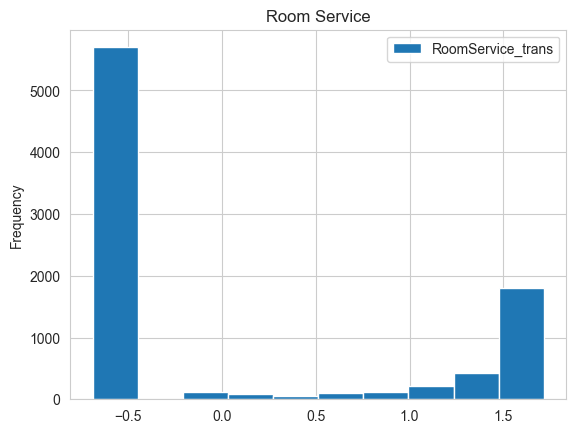

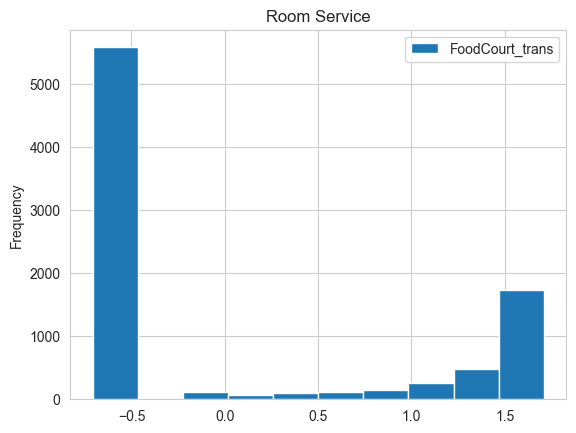

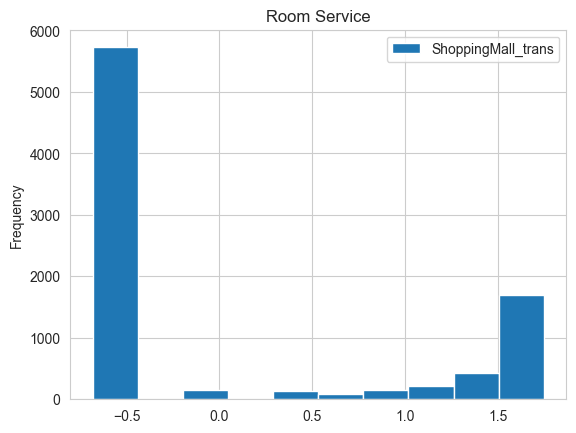

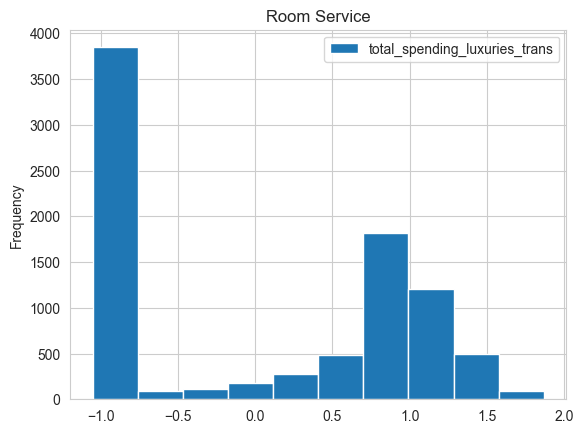

In [426]:
for col in cols_transform:
    df_copy[[f'{col}_trans']] = transformer.fit_transform(df_copy[[col]])
    df_copy[[f'{col}_trans']].plot(kind='hist', title='Room Service')

<Axes: title={'center': 'Room Service'}, ylabel='Frequency'>

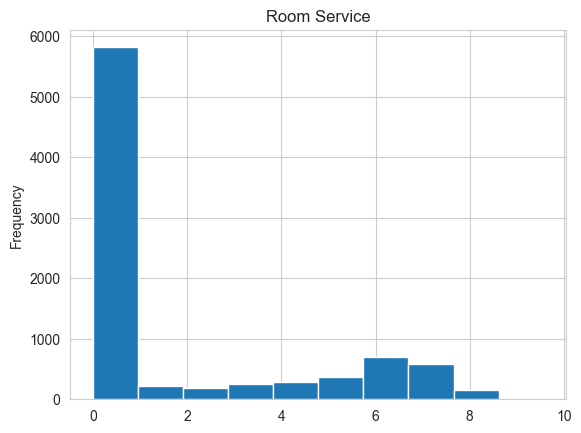

In [422]:
np.log1p(df_copy['RoomService']).plot(kind='hist', title='Room Service')

<Axes: title={'center': 'Room Service'}, ylabel='Frequency'>

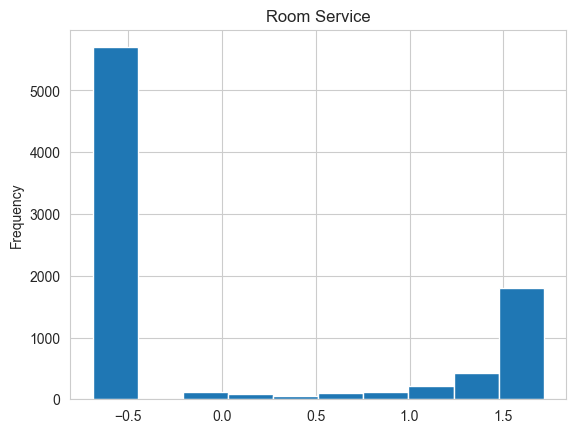

In [421]:
df_copy['RoomService_tranform'].plot(kind='hist', title='Room Service')

# Encoding cat

# Feature selection

# PCA (?)

# Modeling

## Cross validation

## Train 

## Evaluation

## Tuning 

## Evaluation

In [360]:
df_copy = df.copy()

In [361]:
df_copy

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size,total_spending_luxuries
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,False,0,0001,01,B,0,P,Ofracculy,1,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,True,1,0002,01,F,0,S,Vines,1,702.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,False,0,0003,01,A,0,S,Susent,2,6807.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,False,0,0003,02,A,0,S,Susent,2,3522.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,True,1,0004,01,F,1,S,Santantines,1,870.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,...,False,0,9276,01,A,98,P,Noxnuther,1,1717.0
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,...,False,0,9278,01,G,1499,S,Mondalley,1,0.0
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,...,True,1,9279,01,G,1500,S,Connon,1,1.0
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,...,False,0,9280,01,E,608,S,Hontichre,2,3588.0


In [374]:
train_cols = [col for col in df_copy.columns if col not in ['PassengerId', 'Cabin', 'Name', 'Transported', 'target', 'RoomService',
                                                            'Spa', 'VRDeck', 'num_group']]

In [375]:
df_copy[train_cols]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,group,num_group,deck,num_cabin,side_cabin,last_name,group_size,total_spending_luxuries
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0001,01,B,0,P,Ofracculy,1,0.0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,0002,01,F,0,S,Vines,1,702.0
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0003,01,A,0,S,Susent,2,6807.0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0003,02,A,0,S,Susent,2,3522.0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,0004,01,F,1,S,Santantines,1,870.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,9276,01,A,98,P,Noxnuther,1,1717.0
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,9278,01,G,1499,S,Mondalley,1,0.0
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,9279,01,G,1500,S,Connon,1,1.0
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,9280,01,E,608,S,Hontichre,2,3588.0


In [376]:
df_copy = df_copy.dropna()

In [377]:
X_train, X_test, y_train, y_test = train_test_split(df_copy[train_cols],df_copy['target'], test_size=0.2, random_state=42)

In [378]:
cat = [cols for cols in cat_cols if cols in train_cols]

In [379]:
cat_features = cat + ['group', 'deck', 'last_name', 'side_cabin']

In [380]:
train_data = Pool(X_train, y_train, cat_features=cat_features)

In [381]:
test_data = Pool(X_test, y_test, cat_features=cat_features)

In [382]:
model = CatBoostClassifier(loss_function='Logloss',
                           verbose=True)

In [ ]:
model.fit(train_data)

In [384]:
# make the prediction using the resulting model
preds_class = model.predict(test_data)
preds_proba = model.predict_proba(test_data)

In [118]:
print(classification_report(y_test, preds_class))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       722
           1       0.80      0.84      0.82       678

    accuracy                           0.82      1400
   macro avg       0.82      0.82      0.82      1400
weighted avg       0.82      0.82      0.82      1400



In [119]:
f1_score(y_test, preds_class)

0.8192944564434845

In [385]:
print(classification_report(y_test, preds_class))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       859
           1       0.81      0.79      0.80       860

    accuracy                           0.80      1719
   macro avg       0.80      0.80      0.80      1719
weighted avg       0.80      0.80      0.80      1719



In [386]:
f1_score(y_test, preds_class)

0.7974087161366313

In [400]:
model.plot_importance()

AttributeError: 'CatBoostClassifier' object has no attribute 'plot_importance'

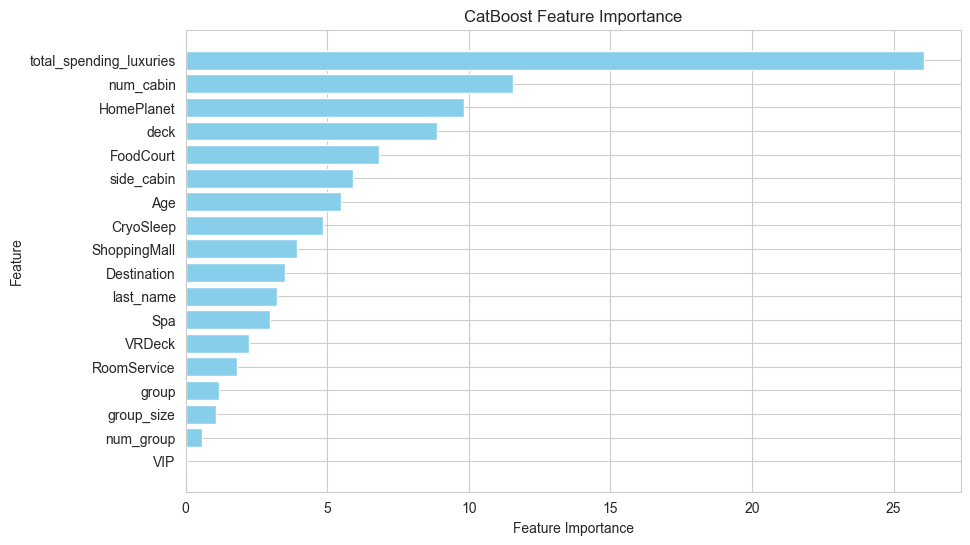

In [401]:
feature_importances = model.get_feature_importance()
feature_names = model.feature_names_

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('CatBoost Feature Importance')
plt.gca().invert_yaxis()  # To have the highest importance on top
plt.show()

In [427]:
data = '../data/spaceship-titanic/'

df_test = pd.read_csv(f'{data}test.csv')

In [431]:
df_test[df_test.isna().any(axis=1)]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
6,0029_01,Europa,True,B/2/P,55 Cancri e,21.0,False,0.0,NaN,0.0,0.0,0.0,Aldah Ainserfle
11,0040_01,Europa,False,D/2/P,TRAPPIST-1e,45.0,False,932.0,74.0,NaN,7.0,1010.0,Antino Pinoffent
15,0046_02,Earth,False,F/11/P,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,903.0,NaN,Glene Powery
18,0047_02,Europa,False,NaN,TRAPPIST-1e,29.0,False,0.0,7708.0,243.0,569.0,343.0,Muons Prucerod
19,0047_03,Europa,False,B/0/S,TRAPPIST-1e,40.0,False,26.0,1925.0,8.0,3144.0,63.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4258,9238_05,Earth,True,NaN,TRAPPIST-1e,14.0,False,0.0,0.0,0.0,0.0,0.0,Caseye Emenez
4267,9260_01,Earth,True,G/1503/P,55 Cancri e,3.0,NaN,0.0,0.0,0.0,0.0,0.0,Luisy Portananney
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import PowerTransformer

from catboost import CatBoostClassifier, Pool

data = '/Users/korotova/pydev/ds_notebooks/data/spaceship-titanic/'

df = pd.read_csv(f'{data}train.csv')
df_test = pd.read_csv(f'{data}test.csv')

cat_cols = df.select_dtypes(include='object').columns.tolist()
num_cols = df.select_dtypes(include='float64').columns.tolist()
bill_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
luxury_cols = ['Spa',  'VRDeck']


def feature_engineering(df):
    df_copy = df.copy()
    df_copy['group'] = df_copy.apply(lambda row: row['PassengerId'].split('_')[0], axis=1)
    df_copy['num_group'] = df_copy.apply(lambda row: row['PassengerId'].split('_')[1], axis=1)
    df_copy['deck'] = df_copy.apply(lambda row: row['Cabin'].split('/')[0] if pd.notna(row['Cabin']) else row['Cabin'], axis=1)
    df_copy['num_cabin'] = df_copy.apply(lambda row: row['Cabin'].split('/')[1] if pd.notna(row['Cabin']) else row['Cabin'],
                               axis=1)
    df_copy['side_cabin'] = df_copy.apply(lambda row: row['Cabin'].split('/')[2] if pd.notna(row['Cabin']) else row['Cabin'],
                                axis=1)
    df_copy['last_name'] = df_copy.apply(lambda row: row['Name'].split()[1] if pd.notna(row['Name']) else row['Name'], axis=1)
    df_copy['total_spending'] = df_copy.apply(lambda row: row[bill_cols].sum(), axis=1)
    df_copy['total_spending_luxuries'] = df_copy.apply(lambda row: row[luxury_cols].sum(), axis=1)

    temp = df_copy.groupby('group').size().reset_index(name='group_size')
    df_copy = df_copy.merge(temp, how='left', on='group')

    return df_copy


def generic_missing_values(df):
    df_copy = df.copy()

    # # fill with mode
    # mode_cols = ['HomePlanet', 'CryoSleep', 'VIP', 'Destination']
    # for col in mode_cols:
    #     mode_value = df_copy[col].mode()[0]
    #     df_copy[col] = df_copy[col].fillna(mode_value)

    # # numeric with zero
    # zero_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    # for col in zero_cols:
    #     df_copy[col] = df_copy[col].fillna(0)

    # # last name with the most frequent in a group
    # group_last_name_count = df_copy[df_copy['group_size'] > 1].groupby(['group', 'last_name']).size().reset_index(name='count')
    # most_frequent_last_name = group_last_name_count.loc[group_last_name_count.groupby('group')['count'].idxmax()]
    # df_copy = df_copy.merge(most_frequent_last_name[['group', 'last_name']], on='group', how='left',
    #               suffixes=('', '_most_frequent'))
    # df_copy['last_name'] = df_copy['last_name'].fillna(df_copy['last_name_most_frequent'])
    # df_copy.drop(columns=['last_name_most_frequent'], inplace=True)
    # 
    # # last name with Unknown for solo travelers
    # df_copy['last_name'] = df_copy['last_name'].fillna('Unknown')

    print(df_copy[df_copy.isna().sum(axis=1) > 0].shape)

    #df_copy = df_copy.dropna()
    return df_copy


def missing_values(df):
    df_copy = df.copy()

    # In CryoSleep people can not spend
    filtered_rows = (df_copy['CryoSleep'] == True) & (df_copy[bill_cols].isna().any(axis=1))
    df_copy.loc[filtered_rows, bill_cols] = df_copy.loc[filtered_rows, bill_cols].fillna(0.0)

    # If people spent they would not be in CryoSleep
    cryosleep_false = (df_copy['CryoSleep'].isna()) & (df_copy[bill_cols].gt(0).any(axis=1))
    df_copy.loc[cryosleep_false, 'CryoSleep'] = False

    #VIP
    vip_false = (df_copy['CryoSleep'] == False) & (df_copy[bill_cols].eq(0).all(axis=1)) & (df_copy['VIP'].isna())
    df_copy.loc[vip_false, 'VIP'] = False

    df_copy.loc[((df_copy['VIP'].isna()) & (df_copy['Age'] < 18)), 'VIP'] = False
    df_copy.loc[((df_copy['VIP'].isna()) & (df_copy['HomePlanet'] == 'Earth')), 'VIP'] = False

    # People from the same group has the same HomePlanet
    # groups_homeplanet = df_copy_copy[['group', 'HomePlanet']].groupby(['group', 'HomePlanet']).nunique().reset_index()
    # df_copy_copy = df_copy_copy.merge(groups_homeplanet, on='group', how='left', suffixes=('', '_from_group'))
    # df_copy_copy['HomePlanet'] = df_copy_copy['HomePlanet'].fillna(df_copy_copy['HomePlanet_from_group'])
    # df_copy_copy.drop(columns=['HomePlanet_from_group'], inplace=True)

    # last name with the most frequent in a group
    group_last_name_count = df_copy[df_copy['group_size'] > 1].groupby(['group', 'last_name']).size().reset_index(name='count')
    most_frequent_last_name = group_last_name_count.loc[group_last_name_count.groupby('group')['count'].idxmax()]
    df_copy = df_copy.merge(most_frequent_last_name[['group', 'last_name']], on='group', how='left',
                  suffixes=('', '_most_frequent'))
    df_copy['last_name'] = df_copy['last_name'].fillna(df_copy['last_name_most_frequent'])
    df_copy.drop(columns=['last_name_most_frequent'], inplace=True)
    df_copy['last_name'] = df_copy['last_name'].fillna('Unknown')

    # People from the same group has the same HomePlanet
    df_copy['HomePlanet'] = df_copy.groupby('group')['HomePlanet'].transform(lambda x: x.ffill().bfill())
    df_copy.loc[(df_copy['deck'] == 'A') & (df_copy['HomePlanet'].isna()), 'HomePlanet'] = 'Europa'
    df_copy.loc[(df_copy['deck'] == 'B') & (df_copy['HomePlanet'].isna()), 'HomePlanet'] = 'Europa'
    df_copy.loc[(df_copy['deck'] == 'G') & (df_copy['HomePlanet'].isna()), 'HomePlanet'] = 'Earth'
    df_copy.loc[(df_copy['deck'] == 'C') & (df_copy['HomePlanet'].isna()), 'HomePlanet'] = 'Europa'
    df_copy.loc[(df_copy['deck'] == 'T') & (df_copy['HomePlanet'].isna()), 'HomePlanet'] = 'Europa'

    last_name_planet = df_copy[df_copy['last_name'] != 'Unknown'].groupby(['last_name',
                                                    'HomePlanet']).size().reset_index()[['last_name', 'HomePlanet']]
    df_copy = df_copy.merge(last_name_planet, on='last_name', how='left', suffixes=('', '_from_names'))
    df_copy['HomePlanet'] = df_copy['HomePlanet'].fillna(df_copy['HomePlanet_from_names'])
    df_copy.drop(columns=['HomePlanet_from_names'], inplace=True)

    df_copy.loc[(df_copy[bill_cols].isna().any(axis=1)) & (df_copy["Age"] < 13), bill_cols] = 0.0

    df_copy['side_cabin'] = df_copy.groupby('group')['side_cabin'].transform(lambda x: x.ffill().bfill())

    df_copy = df_copy.dropna()
    # df_copy = generic_missing_values(df_copy)

    return df_copy

def transforming(df):
    df_copy = df.copy()
    transformer = PowerTransformer(method='yeo-johnson')
    cols_transform = ['RoomService', 'FoodCourt', 'ShoppingMall', 'total_spending_luxuries']
    for col in cols_transform:
        df_copy[[col]] = transformer.fit_transform(df_copy[[col]])
        # df_copy[[col]] = np.log1p(df_copy[[col]])
    return df_copy


def preprocessing(df):
    df_copy = df.copy()
    df_copy = feature_engineering(df_copy)
    df_copy = missing_values(df_copy)
    df_copy = transforming(df_copy)
    return df_copy


def modeling(df):
    df_copy = df.copy()
    df_copy['target'] = df_copy.apply(lambda row: 0 if row['Transported'] == False else 1, axis=1)
    train_cols = [col for col in df_copy.columns if
                  col not in ['PassengerId', 'Cabin', 'Name', 'Transported', 'target',
                              'num_group', 'total_spending',  'Spa', 'VRDeck', 'group']]
    X_train, X_test, y_train, y_test = train_test_split(df_copy[train_cols], df_copy['target'], test_size=0.2,
                                                        random_state=42)
    cat = [cols for cols in cat_cols if cols in train_cols]
    cat_features = cat + ['last_name', 'deck', 'side_cabin']
    train_data = Pool(X_train, y_train, cat_features=cat_features)
    test_data = Pool(X_test, y_test, cat_features=cat_features)
    model = CatBoostClassifier(verbose=True, random_state=42)
    model.fit(train_data)

    preds_class = model.predict(test_data)
    # preds_proba = model.predict_proba(test_data)
    return y_test, preds_class, model


def evaluation(y_test, preds_class):
    print(classification_report(y_test, preds_class))
    print('\n')
    print(f1_score(y_test, preds_class))


def feature_importance(model):
    feature_importances = model.get_feature_importance()
    feature_names = model.feature_names_

    # Create a DataFrame for easy plotting
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('CatBoost Feature Importance')
    plt.gca().invert_yaxis()  # To have the highest importance on top
    plt.show()


def result_test(df, model):
    df_copy = df.copy()
    df_copy = preprocessing(df_copy)
    preds_class = model.predict(df_copy)
    df_copy['Transported'] = preds_class
    df_copy[['PassengerId', 'Transported']].to_csv('../submissions/spaceship_titanic/submission_1.csv',
                                                   index=False)


In [4]:
df_copy = df.copy()
df_copy = preprocessing(df_copy)

/var/folders/7s/ctsz6mrn2736_l3pgbrc0n440000gn/T/ipykernel_35667/804677592.py:105: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy['HomePlanet'] = df_copy.groupby('group')['HomePlanet'].transform(lambda x: x.ffill().bfill())
/var/folders/7s/ctsz6mrn2736_l3pgbrc0n440000gn/T/ipykernel_35667/804677592.py:120: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy['side_cabin'] = df_copy.groupby('group')['side_cabin'].transform(lambda x: x.ffill().bfill())


Learning rate set to 0.0219
0:	learn: 0.6810792	total: 77.9ms	remaining: 1m 17s
1:	learn: 0.6682168	total: 84.8ms	remaining: 42.3s
2:	learn: 0.6559047	total: 92.4ms	remaining: 30.7s
3:	learn: 0.6456257	total: 99.3ms	remaining: 24.7s
4:	learn: 0.6349218	total: 105ms	remaining: 20.9s
5:	learn: 0.6261600	total: 110ms	remaining: 18.2s
6:	learn: 0.6162481	total: 115ms	remaining: 16.4s
7:	learn: 0.6069898	total: 128ms	remaining: 15.8s
8:	learn: 0.5987300	total: 134ms	remaining: 14.7s
9:	learn: 0.5902019	total: 139ms	remaining: 13.8s
10:	learn: 0.5824612	total: 145ms	remaining: 13s
11:	learn: 0.5757296	total: 160ms	remaining: 13.2s
12:	learn: 0.5712536	total: 164ms	remaining: 12.5s
13:	learn: 0.5642446	total: 168ms	remaining: 11.9s
14:	learn: 0.5569348	total: 173ms	remaining: 11.3s
15:	learn: 0.5506072	total: 178ms	remaining: 10.9s
16:	learn: 0.5449843	total: 182ms	remaining: 10.5s
17:	learn: 0.5397342	total: 188ms	remaining: 10.2s
18:	learn: 0.5342897	total: 192ms	remaining: 9.94s
19:	learn:

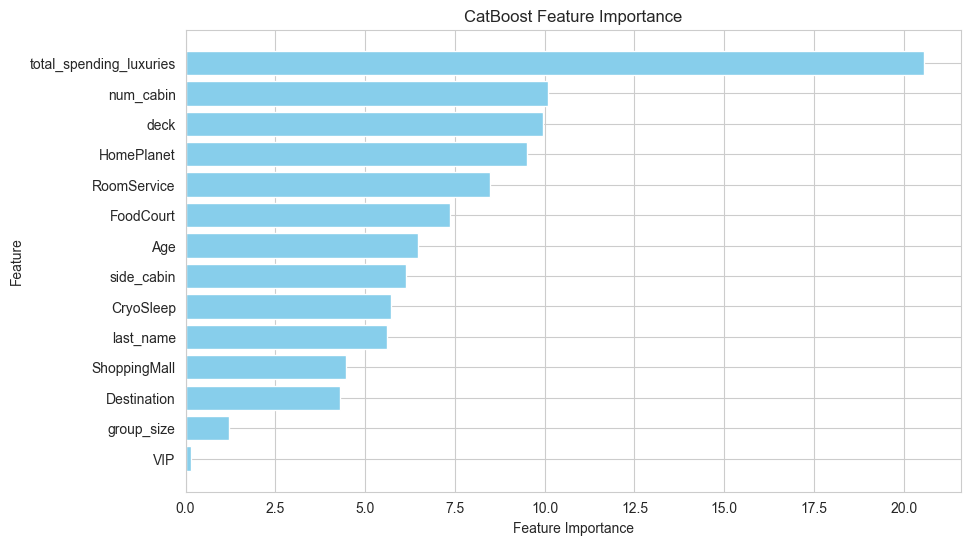

In [7]:
y_test, preds_class, model = modeling(df_copy)
evaluation(y_test, preds_class)
feature_importance(model)

In [5]:
df_copy['target'] = df_copy.apply(lambda row: 0 if row['Transported'] == False else 1, axis=1)
train_cols = [col for col in df_copy.columns if
              col not in ['PassengerId', 'Cabin', 'Name', 'Transported', 'target',
                          'num_group', 'total_spending',  'Spa', 'VRDeck', 'group']]
X_train, X_test, y_train, y_test = train_test_split(df_copy[train_cols], df_copy['target'], test_size=0.2,
                                                    random_state=42)
cat = [cols for cols in cat_cols if cols in train_cols]
cat_features = cat + ['last_name', 'deck', 'side_cabin']
train_data = Pool(X_train, y_train, cat_features=cat_features)
test_data = Pool(X_test, y_test, cat_features=cat_features)

In [6]:
model = CatBoostClassifier(verbose=True, random_state=42, cat_features=cat_features)

In [520]:
param_grid = {
    'depth': [5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [300, 500, 800],
    'l2_leaf_reg': [1, 3, 5]
}

In [523]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1,verbose=10)

In [ ]:
grid_search.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, plot=True)

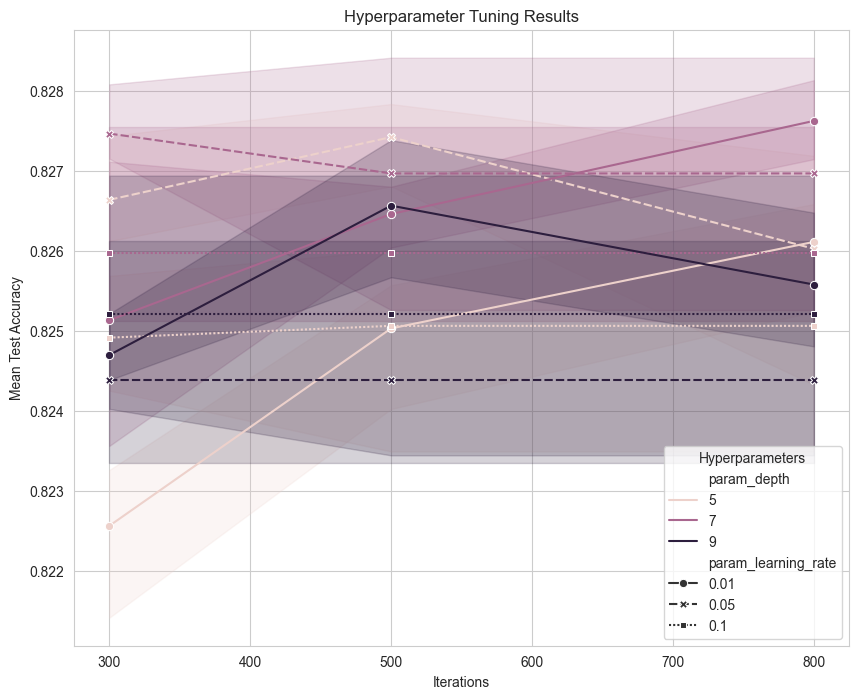

In [525]:
# Visualize the learning process for each parameter combination
results = pd.DataFrame(grid_search.cv_results_)

plt.figure(figsize=(10, 8))
sns.lineplot(x='param_iterations', y='mean_test_score', hue='param_depth', style='param_learning_rate', data=results, markers=True)
plt.title('Hyperparameter Tuning Results')
plt.xlabel('Iterations')
plt.ylabel('Mean Test Accuracy')
plt.legend(title='Hyperparameters', loc='best')
plt.grid(True)
plt.show()

In [526]:
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters: {'depth': 7, 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.05}
Best Cross-Validation Score: 0.8284161160827244


In [528]:
# Use the best parameters for the final model
best_model = grid_search.best_estimator_

In [529]:
# Evaluate the model on the test set
y_pred = best_model.predict(X_test)

In [530]:
evaluation(y_test, y_pred)
feature_importance(model)

              precision    recall  f1-score   support

           0       0.83      0.79      0.81       694
           1       0.81      0.84      0.82       722

    accuracy                           0.82      1416
   macro avg       0.82      0.82      0.82      1416
weighted avg       0.82      0.82      0.82      1416



0.8239292997960571


CatBoostError: Model has no meta information needed to calculate feature importances.                             Pass training dataset to this function.

In [ ]:
df_copy = df.copy()
df_copy = preprocessing(df_copy)
y_test, preds_class, model = modeling(df_copy)
evaluation(y_test, preds_class)
feature_importance(model)

In [466]:
def test_missing(df):
    df_copy = df.copy()

    # numeric with zero
    zero_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    for col in zero_cols:
        df_copy[col] = df_copy[col].fillna(0)

    # last name with the most frequent in a group
    group_last_name_count = df_copy[df_copy['group_size'] > 1].groupby(['group', 'last_name']).size().reset_index(name='count')
    most_frequent_last_name = group_last_name_count.loc[group_last_name_count.groupby('group')['count'].idxmax()]
    df_copy = df_copy.merge(most_frequent_last_name[['group', 'last_name']], on='group', how='left',
                  suffixes=('', '_most_frequent'))
    df_copy['last_name'] = df_copy['last_name'].fillna(df_copy['last_name_most_frequent'])
    df_copy.drop(columns=['last_name_most_frequent'], inplace=True)

    # last name with Unknown for solo travelers
    df_copy['last_name'] = df_copy['last_name'].fillna('Unknown')
    
    vip_false = (df_copy['CryoSleep'] == False) & (df_copy[bill_cols].eq(0).all(axis=1)) & (df_copy['VIP'].isna())
    df_copy.loc[vip_false, 'VIP'] = False
    df_copy['Age'].median()
    df_copy['Age'] = df_copy['Age'].fillna(df_copy['Age'].median())
    group_cabin_count = df_copy[df_copy['group_size'] > 1].groupby(['group', 'Cabin']).size().reset_index(name='count')
    most_frequent_cabin = group_cabin_count.loc[group_cabin_count.groupby('group')['count'].idxmax()]
    df_copy = df_copy.merge(most_frequent_cabin[['group', 'Cabin']], on='group', how='left', suffixes=('', '_most_frequent'))
    df_copy['Cabin'] = df_copy['Cabin'].fillna(df_copy['Cabin_most_frequent'])
    df_copy.drop(columns=['Cabin_most_frequent'], inplace=True)
    
    # fill with mode
    mode_cols = ['HomePlanet', 'CryoSleep', 'VIP', 'Destination', 'deck', 'num_cabin', 'side_cabin']
    for col in mode_cols:
        mode_value = df_copy[col].mode()[0]
        df_copy[col] = df_copy[col].fillna(mode_value)

    print(df_copy[df_copy.isna().sum(axis=1) > 0].shape)

    # df_copy = df_copy.dropna()
    return df_copy


In [544]:

df_test_copy = df_test.copy()
df_test_copy = feature_engineering(df_test_copy)
df_test_copy = missing_values(df_test_copy)
df_test_copy = test_missing(df_test_copy)

(777, 22)
(156, 22)


/var/folders/7s/ctsz6mrn2736_l3pgbrc0n440000gn/T/ipykernel_35559/912209853.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[col] = df_copy[col].fillna(mode_value)


In [545]:
df_test_copy[df_test_copy.isna().any(axis=1)]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,group,num_group,deck,num_cabin,side_cabin,last_name,total_spending,total_spending_luxuries,group_size
19,0047_03,Europa,False,B/0/S,TRAPPIST-1e,40.0,False,26.0,1925.0,8.0,...,NaN,0047,03,B,0,S,Prucerod,5166.0,3207.0,3
99,0227_01,Earth,False,NaN,TRAPPIST-1e,22.0,False,0.0,0.0,0.0,...,Kurta Buckentry,0227,01,F,4,S,Buckentry,0.0,0.0,1
114,0262_01,Earth,False,G/39/S,TRAPPIST-1e,20.0,False,186.0,0.0,0.0,...,NaN,0262,01,G,39,S,Unknown,888.0,702.0,1
135,0293_01,Europa,True,NaN,TRAPPIST-1e,47.0,False,0.0,0.0,0.0,...,Tauxon Suptibler,0293,01,F,4,S,Suptibler,0.0,0.0,1
140,0308_01,Earth,True,G/48/P,PSO J318.5-22,12.0,False,0.0,0.0,0.0,...,NaN,0308,01,G,48,P,Unknown,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4202,9109_01,Earth,True,G/1481/P,TRAPPIST-1e,38.0,False,0.0,0.0,0.0,...,NaN,9109,01,G,1481,P,Unknown,0.0,0.0,1
4209,9138_01,Europa,False,NaN,TRAPPIST-1e,41.0,False,0.0,1998.0,0.0,...,Misamak Trupistic,9138,01,F,4,S,Trupistic,3888.0,1890.0,1
4248,9223_01,Mars,True,NaN,TRAPPIST-1e,24.0,False,0.0,0.0,0.0,...,Weessh Sun,9223,01,F,4,S,Sun,0.0,0.0,2
4249,9223_02,Mars,True,NaN,TRAPPIST-1e,17.0,False,0.0,0.0,0.0,...,Perit Sun,9223,02,F,4,S,Sun,0.0,0.0,2


In [465]:
df_test_copy.side_cabin.value_counts().reset_index()

,side_cabin,count
0,S,2093
1,P,2084


In [464]:
df_test_copy.num_cabin.value_counts().reset_index().sort_values('num_cabin')

,num_cabin,count
114,0,7
238,1,5
292,10,4
366,100,4
620,1001,2
...,...,...
622,993,2
1378,994,1
1379,995,1
451,996,3


In [459]:
df_test_copy.deck.value_counts()

deck
F    1445
G    1222
E     447
B     362
C     355
D     242
A      98
T       6
Name: count, dtype: int64

In [458]:
df_test_copy.isna().sum()

PassengerId                  0
HomePlanet                   0
CryoSleep                    0
Cabin                       63
Destination                  0
Age                          0
VIP                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
Name                        94
group                        0
num_group                    0
deck                       100
num_cabin                  100
side_cabin                 100
last_name                    0
total_spending               0
total_spending_luxuries      0
group_size                   0
dtype: int64

In [454]:
df_test_copy.shape

(4084, 22)

In [546]:
df_test_copy = transforming(df_test_copy)

In [547]:
train_cols = [col for col in df_test_copy.columns if
              col not in ['PassengerId', 'Cabin', 'Name', 'Transported', 'target',
                          'num_group', 'total_spending',  'Spa', 'VRDeck', 'group']]

In [548]:
df_test_copy[train_cols]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,deck,num_cabin,side_cabin,last_name,total_spending_luxuries,group_size
0,Earth,True,TRAPPIST-1e,27.0,False,-0.696518,-0.700731,-0.685448,G,3,S,Carsoning,-0.892515,1
1,Earth,False,TRAPPIST-1e,19.0,False,-0.696518,0.784637,-0.685448,F,4,S,Peckers,1.441877,1
2,Europa,True,55 Cancri e,31.0,False,-0.696518,-0.700731,-0.685448,C,0,S,Unhearfus,-0.892515,1
3,Europa,False,TRAPPIST-1e,38.0,False,-0.696518,1.678074,-0.685448,C,1,S,Caltilter,1.252131,1
4,Earth,False,TRAPPIST-1e,20.0,False,0.894415,-0.700731,1.650548,F,5,S,Harperez,-0.892515,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,Earth,True,TRAPPIST-1e,34.0,False,-0.696518,-0.700731,-0.685448,G,1496,S,Peter,-0.892515,2
4273,Earth,False,TRAPPIST-1e,42.0,False,-0.696518,1.588010,1.152298,F,4,S,Scheron,0.947107,1
4274,Mars,True,55 Cancri e,26.0,False,-0.696518,-0.700731,-0.685448,D,296,P,Pore,-0.892515,1
4275,Europa,False,TRAPPIST-1e,26.0,False,-0.696518,1.647328,-0.685448,D,297,P,Conale,1.187439,1


In [549]:
preds_class = best_model.predict(df_test_copy[train_cols])
df_test_copy['Transported'] = preds_class


In [550]:
df_test_copy['Transported'] = df_test_copy['Transported'].apply(lambda x: True if x==1 else False)

In [551]:
df_test_copy['Transported'].value_counts()

Transported
True     2210
False    2067
Name: count, dtype: int64

In [552]:
df_test_copy[['PassengerId', 'Transported']].to_csv('../submissions/spaceship_titanic/submission_4.csv',
                                               index=False)

In [553]:
df_test_copy.shape

(4277, 23)